![Logo](https://raw.githubusercontent.com/BartaZoltan/deep-reinforcement-learning-course/main/notebooks/shared_assets/logo.png)


**Developers:** Domonkos Nagy, Balazs Nagy, Zoltan Barta  
**Date:** 2026-02-23  
**Version:** 2025-26/2

[<img src="https://colab.research.google.com/assets/colab-badge.svg">](https://colab.research.google.com/github/BartaZoltan/deep-reinforcement-learning-course/blob/main/notebooks/sessions/session_02_mdp_dynamic_programming/session_02_mdp_dynamic_programming.ipynb)

# Practice 2: MDP Dynamic Programming

## Summary

This notebook introduces **tabular Markov Decision Processes (MDPs)** and **Dynamic Programming** control methods in a practical, coding-first format.

Content outline:
- agent-environment interface and reusable GridWorld MDP design,
- Value Iteration implementation and convergence analysis,
- Policy Iteration implementation and behavior analysis,
- larger-map stress tests for scalability and robustness,
- transfer to Gymnasium FrozenLake,
- optional extension: Gambler's Problem.


## Introduction

This practical session develops tabular Dynamic Programming from first principles and then tests it across increasingly realistic environments. Following Sutton and Barto (Ch. 3-4), we start with a fully transparent custom GridWorld to formalize the agent-environment interface, state and action spaces, transition-reward dynamics, and the Markov property. On top of this model, we implement and analyze the two classical planning algorithms for finite MDPs: Value Iteration and Policy Iteration. The focus is not only on obtaining a final policy, but on understanding algorithmic behavior through convergence curves, value-function evolution, policy snapshots, sensitivity studies (e.g., $\gamma$, stopping thresholds, stochasticity), and rollout-based validation. After baseline experiments on small maps, we stress-test both methods on larger layouts to study scalability, robustness, and computational trade-offs. We then transfer the same workflow to Gymnasium FrozenLake to connect custom tabular implementations with standard RL tooling and interface conventions (`reset`, `step`, `terminated`, `truncated`, and transition model access in toy-text environments). As an optional extension, we include Gambler’s Problem to broaden intuition beyond GridWorld and show how the same DP ideas apply to a different tabular structure. By the end of the notebook, you should be able to build a clean tabular MDP, implement both DP control methods correctly, interpret their dynamics with meaningful diagnostics, and move confidently between custom and Gymnasium-based environments.

This notebook follows Chapter 3-4 of Sutton & Barto {cite}`sutton2018`.

## Markov Decision Process, Agent-Environment interface, and GridWorld


In reinforcement learning, the interaction loop is:
- agent observes state $S_t$
- agent takes action $A_t$
- environment returns reward $R_{t+1}$ and next state $S_{t+1}$

The **MDP assumption** is that the future depends on the current state-action pair, not the full history:
$$
P(S_{t+1}, R_{t+1} \mid S_t, A_t)
$$

For planning with Dynamic Programming later, we need an explicit model:
- state space $\mathcal{S}$
- action space $\mathcal{A}$
- transition-reward dynamics $p(s', r \mid s, a)$
- discount factor $\gamma$

### Chess as an MDP: a Markov assumption example

#### MDP framing
- **State (S):** what the agent observes/keeps as the “current situation”
- **Action (A):** a legal chess move
- **Transition (P):** how the position changes after the move (plus rules)
- **Reward (R):** e.g., checkmate = +1, loss = −1, otherwise 0 (example)

#### Markov assumption (informal)
The future depends only on the **current state** and the **chosen action**, not on the whole past:
 $$ P(s_{t+1}, r_{t+1}\mid s_t, a_t, \text{history}) = P(s_{t+1}, r_{t+1}\mid s_t, a_t) $$

#### A “good” Markov state for chess
A state representation that *is* Markov must include all information needed to determine:
1) which moves are legal, and  
2) how rules apply next step.

Example Markov state:
- **board position** (piece placement)
- **side to move**
- **castling rights** (KQkq flags)
- **en passant target square** (or “none”)
- *(optionally)* **halfmove clock** and **fullmove number** (for draw rules)

With this, legality and next-position dynamics can be computed **without knowing earlier moves**.

#### Why a “board-only” state is NOT Markov
If you define the state as only:
- **S = piece placement on the board**

then the process becomes non-Markov because the same board layout can correspond to different legal moves depending on history.

#### Counterexample 1: Castling
Two histories can lead to the same piece placement, but:
- in one, the king/rook moved earlier → **castling is illegal**
- in the other, they never moved → **castling is legal**

So legality (and thus transitions) depends on the past unless castling rights are in the state.

#### Counterexample 2: En passant
The same board layout may occur, but:
- if the opponent just advanced a pawn two squares last move → **en passant is legal now**
- otherwise → **en passant is not legal**

So you must store the en passant target square (or equivalent) to satisfy the Markov property.

#### Takeaway
- Chess is Markov **given a sufficiently rich state** (board + turn + castling rights + en passant + …).
- If you omit “hidden memory” variables and keep only the board, the environment behaves like a **POMDP** (history matters).

So in this part we build a GridWorld that supports both:
- a simulator-like API (`reset`, `step`) for rollouts,
- and a tabular model (`P[s][a]`) for Value/Policy Iteration

In [1]:
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional
from pathlib import Path
import time
import base64

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.collections import LineCollection
from matplotlib.animation import FuncAnimation, PillowWriter

from IPython.display import Image as DisplayImage, display, HTML

try:
    from PIL import Image as PILImage
except Exception:
    PILImage = None

try:
    import imageio.v2 as imageio
except Exception:
    imageio = None

try:
    import gymnasium as gym
except Exception:
    gym = None

SEED = 42
rng = np.random.default_rng(SEED)

# Action encoding for consistency across all later parts
UP, RIGHT, DOWN, LEFT = 0, 1, 2, 3
ACTIONS = {
    UP: (-1, 0),
    RIGHT: (0, 1),
    DOWN: (1, 0),
    LEFT: (0, -1),
}
ACTION_SYMBOLS = {UP: "↑", RIGHT: "→", DOWN: "↓", LEFT: "←"}
Transition = Tuple[float, int, float, bool]  # (prob, next_state, reward, done)


### Task 1

**Build a Reusable GridWorld MDP Environment (10-15 min)**

In this task you implement the environment side of the MDP-agent interface so the same class can be used both for simulation (`reset`, `step`) and for planning (`as_mdp`). Most of the class is already provided. 

The map uses characters with the following meaning: `S` is the unique start cell, `.` is a free cell, `#` is a wall, `G` is a goal terminal cell, and `H` is a hole terminal cell. Walls are not valid states. Every non-wall cell must have a state index and be reachable through `pos_to_state` / `state_to_pos`.

Your implementation should respect the modeling assumptions used later by Value Iteration and Policy Iteration. Terminal states are absorbing in the transition model, invalid moves (off-grid or into a wall) keep the agent in place, and transition stochasticity is handled through `slip_prob` in `_build_transition_model()` (already scaffolded for you).

What you need to implement in the marked code blocks:
- In `reset()`, set the internal current state (`self._state`) back to `self.start_state`, then return it.
- In `step(action)`, validate action, sample one transition from `self._P[self._state][action]` using transition probabilities, update `self._state` to the sampled next state, and return `(next_state, reward, done, {})`.

Do not change function signatures or return types, because later notebook cells assume this exact API.

A correct implementation should satisfy these sanity checks:
- `reset()` always returns the start state.
- `step()` raises an error for invalid actions.
- Transition sampling follows model probabilities.
- The returned state is consistent with `self._state` after each step.
- `as_mdp()` produces an object that works directly with DP algorithms in the next tasks.


In [2]:
@dataclass
class GridWorldConfig:
    char_map: List[str]
    step_reward: float = -1.0
    goal_reward: float = 10.0
    hole_reward: float = -10.0
    slip_prob: float = 0.0  # 0.0 = deterministic dynamics


@dataclass
class TabularMDP:
    nS: int
    nA: int
    P: Dict[int, Dict[int, List[Transition]]]
    state_to_pos: Dict[int, Tuple[int, int]]
    pos_to_state: Dict[Tuple[int, int], int]
    terminal_states: set
    start_state: int
    grid_chars: np.ndarray


### GridWorld implementation details

This class exposes:
- `reset()` and `step(action)` for interaction,
- `as_mdp()` that returns a full tabular model for planning algorithms.

This keeps one source of truth for dynamics and avoids mismatch bugs later.


In [3]:
class GridWorldEnv:
    def __init__(self, cfg: GridWorldConfig):
        self.cfg = cfg
        self.grid = np.array([list(row) for row in cfg.char_map], dtype="<U1")
        self.H, self.W = self.grid.shape

        self.pos_to_state: Dict[Tuple[int, int], int] = {}
        self.state_to_pos: Dict[int, Tuple[int, int]] = {}

        s_idx = 0
        for r in range(self.H):
            for c in range(self.W):
                if self.grid[r, c] != "#":
                    self.pos_to_state[(r, c)] = s_idx
                    self.state_to_pos[s_idx] = (r, c)
                    s_idx += 1

        self.nS = s_idx
        self.nA = 4

        self.terminal_states = set()
        self.start_state: Optional[int] = None

        for (r, c), s in self.pos_to_state.items():
            cell = self.grid[r, c]
            if cell in ("G", "H"):
                self.terminal_states.add(s)
            if cell == "S":
                if self.start_state is not None:
                    raise ValueError("Map must contain exactly one start cell 'S'.")
                self.start_state = s

        if self.start_state is None:
            raise ValueError("Map must contain one start cell 'S'.")

        self._P = self._build_transition_model()
        self._state = self.start_state

    def _move(self, r: int, c: int, a: int) -> Tuple[int, int]:
        dr, dc = ACTIONS[a]
        nr, nc = r + dr, c + dc
        if nr < 0 or nr >= self.H or nc < 0 or nc >= self.W or self.grid[nr, nc] == "#":
            return r, c
        return nr, nc

    def _cell_reward_done(self, r: int, c: int) -> Tuple[float, bool]:
        cell = self.grid[r, c]
        if cell == "G":
            return self.cfg.goal_reward, True
        if cell == "H":
            return self.cfg.hole_reward, True
        return self.cfg.step_reward, False

    def _build_transition_model(self) -> Dict[int, Dict[int, List[Transition]]]:
        left_of = {UP: LEFT, RIGHT: UP, DOWN: RIGHT, LEFT: DOWN}
        right_of = {UP: RIGHT, RIGHT: DOWN, DOWN: LEFT, LEFT: UP}

        P: Dict[int, Dict[int, List[Transition]]] = {
            s: {a: [] for a in range(self.nA)} for s in range(self.nS)
        }

        for s, (r, c) in self.state_to_pos.items():
            if s in self.terminal_states:
                for a in range(self.nA):
                    P[s][a] = [(1.0, s, 0.0, True)]
                continue

            for a in range(self.nA):
                outcomes = [(1.0 - self.cfg.slip_prob, a)]
                if self.cfg.slip_prob > 0:
                    outcomes.append((self.cfg.slip_prob / 2.0, left_of[a]))
                    outcomes.append((self.cfg.slip_prob / 2.0, right_of[a]))

                acc: Dict[Tuple[int, float, bool], float] = {}
                for p, a_eff in outcomes:
                    nr, nc = self._move(r, c, a_eff)
                    s_next = self.pos_to_state[(nr, nc)]
                    reward, done = self._cell_reward_done(nr, nc)
                    key = (s_next, reward, done)
                    acc[key] = acc.get(key, 0.0) + p

                P[s][a] = [(p, s_next, reward, done) for (s_next, reward, done), p in acc.items()]

        return P

    def reset(self) -> int:
        ########################################################################
        self._state = self.start_state
        ########################################################################
        return self._state

    def step(self, action: int) -> Tuple[int, float, bool, dict]:
        ########################################################################
        if action not in ACTIONS:
            raise ValueError(f"Invalid action {action}. Must be in {list(ACTIONS.keys())}.")

        transitions = self._P[self._state][action]
        probs = np.array([p for p, _, _, _ in transitions], dtype=float)
        idx = int(rng.choice(len(transitions), p=probs))
        _, s_next, reward, done = transitions[idx]

        self._state = s_next
        ########################################################################
        return s_next, reward, done, {}

    def as_mdp(self) -> TabularMDP:
        return TabularMDP(
            nS=self.nS,
            nA=self.nA,
            P=self._P,
            state_to_pos=self.state_to_pos,
            pos_to_state=self.pos_to_state,
            terminal_states=self.terminal_states,
            start_state=self.start_state,
            grid_chars=self.grid,
        )


### GridWorld diagnostics and sanity checks

Before running any algorithms, we should verify the environment logic visually:
- map rendering,
- greedy/random rollout trace,
- transition probability sanity check (`sum_p = 1`).


In [4]:
def _draw_cell_grid(ax, H: int, W: int) -> None:
    # Draw grid lines on cell borders (not through cell centers)
    ax.set_xticks(np.arange(-0.5, W, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, H, 1), minor=True)
    ax.grid(which="minor", color="gray", linewidth=0.8)
    ax.tick_params(which="minor", bottom=False, left=False)
    ax.set_xlim(-0.5, W - 0.5)
    ax.set_ylim(H - 0.5, -0.5)


def _map_code_array(grid_chars: np.ndarray) -> np.ndarray:
    # Supports custom GridWorld and FrozenLake chars
    code_map = {"#": 0, ".": 1, "F": 1, "S": 2, "G": 3, "H": 4}
    arr = np.full(grid_chars.shape, 1, dtype=int)
    for r in range(grid_chars.shape[0]):
        for c in range(grid_chars.shape[1]):
            arr[r, c] = code_map.get(grid_chars[r, c], 1)
    return arr


def values_to_grid(mdp: TabularMDP, V: np.ndarray) -> np.ndarray:
    H, W = mdp.grid_chars.shape
    grid = np.full((H, W), np.nan, dtype=float)
    for s, (r, c) in mdp.state_to_pos.items():
        grid[r, c] = V[s]
    return grid


def _text_color_for_value(v: float, vmin: float, vmax: float, threshold: float = 0.55) -> str:
    if not np.isfinite(v):
        return "black"
    if vmax <= vmin:
        return "black"
    norm = (v - vmin) / (vmax - vmin)
    return "white" if norm < threshold else "black"


def render_map(env: GridWorldEnv, title: str = "GridWorld map") -> None:
    arr = _map_code_array(env.grid)
    cmap = ListedColormap(["black", "white", "#A7D3F5", "#B7E4C7", "#F8B4B4"])

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(arr, cmap=cmap, vmin=0, vmax=4)
    ax.set_title(title)
    ax.set_xticks(range(env.W))
    ax.set_yticks(range(env.H))
    _draw_cell_grid(ax, env.H, env.W)

    for r in range(env.H):
        for c in range(env.W):
            txt = " " if env.grid[r, c] in (".", "F") else env.grid[r, c]
            ax.text(c, r, txt, ha="center", va="center", color="black", fontsize=12, fontweight="bold")

    plt.tight_layout()
    plt.show()


def render_policy_arrows(mdp: TabularMDP, greedy_actions: np.ndarray, title: str = "Policy arrows") -> None:
    H, W = mdp.grid_chars.shape
    bg = np.zeros((H, W), dtype=float)

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(bg, cmap=ListedColormap(["#f7f7f7"]))
    ax.set_title(title)
    ax.set_xticks(range(W))
    ax.set_yticks(range(H))
    _draw_cell_grid(ax, H, W)

    for r in range(H):
        for c in range(W):
            ch = mdp.grid_chars[r, c]
            if ch == "#":
                txt = "#"
            elif ch in ("G", "H"):
                txt = ch
            else:
                s = mdp.pos_to_state[(r, c)]
                txt = ACTION_SYMBOLS[int(greedy_actions[s])]
            ax.text(c, r, txt, ha="center", va="center", color="black", fontsize=12, fontweight="bold")

    plt.tight_layout()
    plt.show()


def validate_transition_model(mdp: TabularMDP) -> None:
    for s in range(mdp.nS):
        for a in range(mdp.nA):
            p_sum = sum(p for p, _, _, _ in mdp.P[s][a])
            if not np.isclose(p_sum, 1.0):
                raise AssertionError(f"Transition probabilities do not sum to 1 at state={s}, action={a}: {p_sum}")
    print("Transition model sanity check passed (all action distributions sum to 1).")


def plot_visitation_heatmap(env: GridWorldEnv, counts: np.ndarray, title: str = "Random policy visitation"):
    grid = np.full((env.H, env.W), np.nan, dtype=float)
    for s, (r, c) in env.state_to_pos.items():
        grid[r, c] = counts[s]

    fig, ax = plt.subplots(figsize=(5, 5))
    im = ax.imshow(grid, cmap="magma")
    ax.set_title(title)
    ax.set_xticks(range(env.W))
    ax.set_yticks(range(env.H))
    _draw_cell_grid(ax, env.H, env.W)

    max_v = np.nanmax(grid) if np.any(~np.isnan(grid)) else 1.0
    for r in range(env.H):
        for c in range(env.W):
            ch = env.grid[r, c]
            if ch == "#":
                ax.text(c, r, "#", ha="center", va="center", color="white", fontweight="bold")
            elif not np.isnan(grid[r, c]):
                color = "black" if grid[r, c] > 0.45 * max_v else "white"
                ax.text(c, r, f"{int(grid[r, c])}", ha="center", va="center", color=color, fontsize=9)

    fig.colorbar(im, ax=ax, shrink=0.8, label="visit count")
    plt.tight_layout()
    plt.show()


def plot_value_heatmap(mdp: TabularMDP, V: np.ndarray, title: str = "Value heatmap"):
    grid = values_to_grid(mdp, V)
    H, W = grid.shape

    fig, ax = plt.subplots(figsize=(5, 5))
    im = ax.imshow(grid, cmap="viridis")
    ax.set_title(title)
    ax.set_xticks(range(W))
    ax.set_yticks(range(H))
    _draw_cell_grid(ax, H, W)

    finite_vals = grid[np.isfinite(grid)]
    vmin = float(np.min(finite_vals)) if finite_vals.size else 0.0
    vmax = float(np.max(finite_vals)) if finite_vals.size else 1.0

    for r in range(H):
        for c in range(W):
            ch = mdp.grid_chars[r, c]
            if ch == "#":
                ax.text(c, r, "#", ha="center", va="center", color="white", fontweight="bold")
            elif np.isfinite(grid[r, c]):
                color = _text_color_for_value(grid[r, c], vmin, vmax, threshold=0.55)
                ax.text(c, r, f"{grid[r, c]:.1f}", ha="center", va="center", color=color, fontsize=9)

    fig.colorbar(im, ax=ax, shrink=0.8, label="V(s)")
    plt.tight_layout()
    plt.show()


def plot_vi_convergence(deltas: list, title: str = "Value Iteration convergence"):
    fig, ax = plt.subplots(figsize=(6, 3.5))
    ax.plot(deltas, lw=2)
    ax.set_yscale("log")
    ax.set_xlabel("Sweep")
    ax.set_ylabel("max update delta")
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_vi_snapshots(mdp: TabularMDP, history: list, k_list=None, title_prefix: str = "VI snapshot"):
    if not history:
        return
    if k_list is None:
        last = len(history) - 1
        mid = last // 2
        k_list = sorted(set([0, mid, last]))

    fig, axes = plt.subplots(1, len(k_list), figsize=(4 * len(k_list), 4))
    if len(k_list) == 1:
        axes = [axes]

    all_grids = [values_to_grid(mdp, history[k]) for k in k_list]
    all_vals = np.concatenate([g[np.isfinite(g)] for g in all_grids if np.any(np.isfinite(g))])
    vmin = float(np.min(all_vals)) if all_vals.size else 0.0
    vmax = float(np.max(all_vals)) if all_vals.size else 1.0

    for ax, k in zip(axes, k_list):
        grid = values_to_grid(mdp, history[k])
        im = ax.imshow(grid, cmap="viridis")
        ax.set_title(f"{title_prefix} k={k+1}")
        ax.set_xticks(range(grid.shape[1]))
        ax.set_yticks(range(grid.shape[0]))
        _draw_cell_grid(ax, grid.shape[0], grid.shape[1])

        for r in range(grid.shape[0]):
            for c in range(grid.shape[1]):
                ch = mdp.grid_chars[r, c]
                if ch == "#":
                    ax.text(c, r, "#", ha="center", va="center", color="white", fontweight="bold")
                elif np.isfinite(grid[r, c]):
                    color = _text_color_for_value(grid[r, c], vmin, vmax, threshold=0.55)
                    ax.text(c, r, f"{grid[r, c]:.1f}", ha="center", va="center", color=color, fontsize=8)

    fig.colorbar(im, ax=axes, shrink=0.75)
    plt.tight_layout()
    plt.show()


def _draw_policy_on_axis(ax, mdp: TabularMDP, actions: np.ndarray, title: str):
    arr = np.zeros(mdp.grid_chars.shape, dtype=float)
    ax.imshow(arr, cmap=ListedColormap(["#f7f7f7"]))
    ax.set_title(title, fontsize=11)
    ax.set_xticks(range(arr.shape[1]))
    ax.set_yticks(range(arr.shape[0]))
    _draw_cell_grid(ax, arr.shape[0], arr.shape[1])

    for r in range(arr.shape[0]):
        for c in range(arr.shape[1]):
            ch = mdp.grid_chars[r, c]
            if ch == "#":
                txt = "#"
            elif ch in ("G", "H"):
                txt = ch
            else:
                s = mdp.pos_to_state[(r, c)]
                txt = ACTION_SYMBOLS[int(actions[s])]
            ax.text(c, r, txt, ha="center", va="center", color="black", fontsize=11, fontweight="bold")


def _draw_value_on_axis(ax, mdp: TabularMDP, V: np.ndarray, title: str):
    grid = values_to_grid(mdp, V)
    im = ax.imshow(grid, cmap="viridis")
    ax.set_title(title, fontsize=11)
    ax.set_xticks(range(grid.shape[1]))
    ax.set_yticks(range(grid.shape[0]))
    _draw_cell_grid(ax, grid.shape[0], grid.shape[1])

    finite_vals = grid[np.isfinite(grid)]
    vmin = float(np.min(finite_vals)) if finite_vals.size else 0.0
    vmax = float(np.max(finite_vals)) if finite_vals.size else 1.0

    for r in range(grid.shape[0]):
        for c in range(grid.shape[1]):
            ch = mdp.grid_chars[r, c]
            if ch == "#":
                ax.text(c, r, "#", ha="center", va="center", color="white", fontweight="bold")
            elif np.isfinite(grid[r, c]):
                color = _text_color_for_value(grid[r, c], vmin, vmax, threshold=0.55)
                ax.text(c, r, f"{grid[r, c]:.1f}", ha="center", va="center", color=color, fontsize=8)

    return im




def _display_saved_media(path: Path) -> None:
    display(DisplayImage(filename=str(path)))



def _in_colab() -> bool:
    try:
        import google.colab  # type: ignore
        return True
    except Exception:
        return False


def _display_media_row(paths: List[Path], width_px: int = 420) -> None:
    tags = []
    colab = _in_colab()

    for p in paths:
        p = Path(p)
        ext = p.suffix.lower().lstrip('.')
        mime = 'image/gif' if ext == 'gif' else f"image/{'jpeg' if ext in ('jpg', 'jpeg') else ext}"

        if colab:
            b64 = base64.b64encode(p.read_bytes()).decode('utf-8')
            src = f'data:{mime};base64,{b64}'
        else:
            src = p.as_posix()

        tags.append(f'<img src="{src}" style="width:{width_px}px;max-width:48%;height:auto;"/>')

    html = "<div style='display:flex;gap:12px;align-items:flex-start;flex-wrap:wrap;'>" + "".join(tags) + "</div>"
    display(HTML(html))


def _save_or_show_fig(fig, save: bool, path: Path | None = None, showcase: bool = True) -> None:
    if save:
        if path is None:
            raise ValueError("path must be provided when save=True")
        path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(path, dpi=160, bbox_inches="tight")
        plt.close(fig)
        print(f"Saved PNG: {path}")
        if showcase:
            _display_saved_media(path)
    else:
        fig.tight_layout()
        plt.show()


def _finalize_gif_animation(
    ani,
    fig,
    save: bool = False,
    gif_path: Path | None = None,
    fps: int = 6,
    showcase: bool = True,
):
    if save:
        if gif_path is None:
            raise ValueError("gif_path must be provided when save=True")
        gif_path.parent.mkdir(parents=True, exist_ok=True)
        ani.save(gif_path, writer=PillowWriter(fps=fps))
        plt.close(fig)
        print(f"Saved GIF: {gif_path}")
        if showcase:
            _display_saved_media(gif_path)
    else:
        display(HTML(ani.to_jshtml()))
        plt.close(fig)


def save_vi_value_gif(
    mdp: TabularMDP,
    history: list,
    gif_path: Path | None = None,
    title_prefix: str = "VI value evolution",
    save: bool = False,
    fps: int = 6,
    showcase: bool = True,
):
    if not history:
        print("No history available; GIF was not created.")
        return

    grids = [values_to_grid(mdp, V) for V in history]
    H, W = grids[0].shape
    all_vals = np.concatenate([g[np.isfinite(g)] for g in grids if np.any(np.isfinite(g))])
    vmin = float(np.min(all_vals)) if all_vals.size else 0.0
    vmax = float(np.max(all_vals)) if all_vals.size else 1.0

    fig, ax = plt.subplots(figsize=(5, 5))
    im = ax.imshow(grids[0], cmap="viridis")
    txt = ax.set_title(f"{title_prefix} | sweep=1")
    ax.set_xticks(range(W))
    ax.set_yticks(range(H))
    _draw_cell_grid(ax, H, W)

    text_art = {}
    for r in range(H):
        for c in range(W):
            ch = mdp.grid_chars[r, c]
            if ch == "#":
                text_art[(r, c)] = ax.text(c, r, "#", ha="center", va="center", color="white", fontweight="bold")
            elif ch in ("G", "H"):
                text_art[(r, c)] = ax.text(c, r, ch, ha="center", va="center", color="black", fontweight="bold")
            elif np.isfinite(grids[0][r, c]):
                color = _text_color_for_value(grids[0][r, c], vmin, vmax, threshold=0.55)
                text_art[(r, c)] = ax.text(c, r, f"{grids[0][r, c]:.1f}", ha="center", va="center", color=color, fontsize=8)

    def update(frame_idx):
        g = grids[frame_idx]
        im.set_data(g)
        txt.set_text(f"{title_prefix} | sweep={frame_idx + 1}")
        for (r, c), artist in text_art.items():
            ch = mdp.grid_chars[r, c]
            if ch in ("#", "G", "H"):
                continue
            if np.isfinite(g[r, c]):
                artist.set_text(f"{g[r, c]:.1f}")
                artist.set_color(_text_color_for_value(g[r, c], vmin, vmax, threshold=0.55))
        return (im, txt, *text_art.values())

    ani = FuncAnimation(fig, update, frames=len(grids), interval=180, blit=False)
    _finalize_gif_animation(ani, fig, save=save, gif_path=gif_path, fps=fps, showcase=showcase)


def save_vi_convergence_png(

    deltas: list,
    png_path: Path | None = None,
    title: str = "VI convergence",
    save: bool = False,
    showcase: bool = True,
):
    if not deltas:
        print("No deltas available; PNG was not created.")
        return

    if save and png_path is None:
        raise ValueError("png_path must be provided when save=True")

    if save:
        png_path.parent.mkdir(parents=True, exist_ok=True)

    fig, ax = plt.subplots(figsize=(6, 3.5))
    ax.plot(deltas, lw=2)
    ax.set_yscale("log")
    ax.set_xlabel("Sweep")
    ax.set_ylabel("max update delta")
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    fig.tight_layout()
    if save:
        fig.savefig(png_path, dpi=160, bbox_inches="tight")
        plt.close(fig)
        print(f"Saved PNG: {png_path}")
        if showcase:
            _display_saved_media(png_path)
    else:
        plt.show()


def save_trajectory_gif(
    env,
    states: List[int],
    gif_path: Path | None = None,
    title: str = "Trajectory evolution",
    fps: int = 6,
    interval_ms: int = 170,
    trail_len: int = 18,
    save: bool = False,
    showcase: bool = True,
):

    pts = np.array([env.state_to_pos[s] for s in states], dtype=float)
    ys, xs = pts[:, 0], pts[:, 1]

    arr = _map_code_array(env.grid)
    cmap = ListedColormap(["black", "white", "#A7D3F5", "#B7E4C7", "#F8B4B4"])

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(arr, cmap=cmap, vmin=0, vmax=4)
    ax.set_title(title)
    ax.set_xticks(range(env.W))
    ax.set_yticks(range(env.H))
    _draw_cell_grid(ax, env.H, env.W)

    for r in range(env.H):
        for c in range(env.W):
            txt = " " if env.grid[r, c] in (".", "F") else env.grid[r, c]
            ax.text(c, r, txt, ha="center", va="center", color="black", fontsize=10, fontweight="bold")

    lc = LineCollection([], linewidths=2.5, capstyle="round")
    ax.add_collection(lc)

    ax.scatter(xs[0], ys[0], color="orange", s=90, zorder=6, label="start")
    head = ax.scatter([], [], color="red", s=75, zorder=7, label="current")
    ax.legend(loc="upper right")

    base_rgb = np.array([31/255, 119/255, 180/255])

    def update(i):
        if i == 0:
            lc.set_segments([])
            head.set_offsets([[xs[0], ys[0]]])
            return lc, head

        start_idx = max(0, i - trail_len)
        segs, cols = [], []
        window = i - start_idx

        for j in range(start_idx, i):
            segs.append([(xs[j], ys[j]), (xs[j + 1], ys[j + 1])])
            age = i - j
            alpha = max(0.08, 1.0 - (age - 1) / max(1, window))
            cols.append((base_rgb[0], base_rgb[1], base_rgb[2], alpha))

        lc.set_segments(segs)
        lc.set_color(cols)
        head.set_offsets([[xs[i], ys[i]]])
        return lc, head

    ani = FuncAnimation(fig, update, frames=len(states), interval=interval_ms, blit=False)
    _finalize_gif_animation(ani, fig, save=save, gif_path=gif_path, fps=fps, showcase=showcase)



def plot_value_pair(
    mdp_left: TabularMDP,
    V_left: np.ndarray,
    title_left: str,
    mdp_right: TabularMDP,
    V_right: np.ndarray,
    title_right: str,
    save: bool = False,
    png_path: Path | None = None,
    showcase: bool = True,
):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4.5))
    im_l = _draw_value_on_axis(axes[0], mdp_left, V_left, title_left)
    im_r = _draw_value_on_axis(axes[1], mdp_right, V_right, title_right)
    fig.colorbar(im_l, ax=axes[0], shrink=0.8, label='V(s)')
    fig.colorbar(im_r, ax=axes[1], shrink=0.8, label='V(s)')
    _save_or_show_fig(fig, save=save, path=png_path if save else None, showcase=showcase)


def plot_vi_convergence_pair(
    deltas_det: list,
    deltas_slip: list,
    save: bool = False,
    png_path: Path | None = None,
    title: str = 'VI convergence comparison',
    showcase: bool = True,
):
    fig, axes = plt.subplots(1, 2, figsize=(11, 3.8), sharey=True)
    curves = [
        (deltas_det, 'Deterministic'),
        (deltas_slip, 'Slippery'),
    ]
    for ax, (deltas, name) in zip(axes, curves):
        ax.plot(deltas, lw=2)
        ax.set_yscale('log')
        ax.set_xlabel('Sweep')
        ax.set_title(name)
        ax.grid(True, alpha=0.3)
    axes[0].set_ylabel('max update delta')
    fig.suptitle(title)
    fig.tight_layout()
    _save_or_show_fig(fig, save=save, path=png_path if save else None, showcase=showcase)


def plot_pi_convergence_pair(
    pi_det: dict,
    pi_slip: dict,
    save: bool = False,
    png_path: Path | None = None,
    title: str = 'PI convergence comparison',
    showcase: bool = True,
):
    fig, axes = plt.subplots(1, 2, figsize=(11, 3.8), sharey=True)
    curves = [
        (pi_det, 'Deterministic'),
        (pi_slip, 'Slippery'),
    ]
    for ax, (res, name) in zip(axes, curves):
        ax.plot(res['eval_sweeps'], marker='o', lw=2)
        ax.set_xlabel('Outer loop')
        ax.set_title(name)
        ax.grid(True, alpha=0.3)
    axes[0].set_ylabel('Policy-evaluation sweeps')
    fig.suptitle(title)
    fig.tight_layout()
    _save_or_show_fig(fig, save=save, path=png_path if save else None, showcase=showcase)


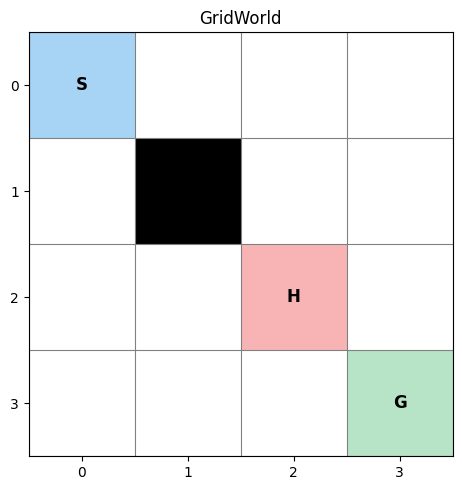

Transition model sanity check passed (all action distributions sum to 1).
nS=15, nA=4, start=0, terminal_states=[9, 14]


In [5]:
# Example map intended for later Value/Policy Iteration experiments
char_map = [
    "S...",
    ".#..",
    "..H.",
    "...G",
]

cfg = GridWorldConfig(
    char_map=char_map,
    step_reward=-1.0,
    goal_reward=10.0,
    hole_reward=-10.0,
    slip_prob=0.10,
)

env = GridWorldEnv(cfg)
mdp = env.as_mdp()

render_map(env, "GridWorld")
validate_transition_model(mdp)
print(f"nS={mdp.nS}, nA={mdp.nA}, start={mdp.start_state}, terminal_states={sorted(mdp.terminal_states)}")


This map defines the full planning problem that the dynamic-programming algorithms will solve. Walls shape the feasible state transitions, the goal provides positive terminal reward, and holes end the episode with negative payoff. Reading this map first is important because all later value and policy patterns are direct consequences of this transition structure.

In [6]:
# Quick rollout demo with a random policy to validate reset/step interface
state = env.reset()
trajectory = [state]
rewards = []

for t in range(25):
    action = int(rng.integers(0, env.nA))
    next_state, reward, done, _ = env.step(action)
    trajectory.append(next_state)
    rewards.append(reward)
    if done:
        break

print("Rollout length:", len(trajectory) - 1)
print("Total reward:", float(np.sum(rewards)))
print("Visited states:", trajectory)


Rollout length: 25
Total reward: -25.0
Visited states: [0, 0, 0, 0, 0, 4, 4, 4, 0, 0, 4, 4, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 2]


### Experiments - Random walk and diagnostics

These experiments deepen intuition before dynamic programming algorithms.

1. Random-walk baseline performance.
2. Monte Carlo visitation heatmap.
3. Transition probability sanity probes.
4. Reward sensitivity sweep.
5. Single-episode trajectory visualization.


In [7]:
def run_random_episode(env: GridWorldEnv, max_steps: int = 200):
    state = env.reset()
    states = [state]
    actions = []
    rewards = []

    done = False
    for _ in range(max_steps):
        a = int(rng.integers(0, env.nA))
        s_next, r, done, _ = env.step(a)
        actions.append(a)
        rewards.append(r)
        states.append(s_next)
        if done:
            break

    return {
        "states": states,
        "actions": actions,
        "rewards": rewards,
        "done": done,
        "return": float(np.sum(rewards)),
        "length": len(actions),
        "terminal_state": states[-1],
    }


def evaluate_random_policy(env: GridWorldEnv, n_episodes: int = 2000, max_steps: int = 200):
    success = 0
    holes = 0
    timeouts = 0
    returns = []
    lengths = []

    for _ in range(n_episodes):
        ep = run_random_episode(env, max_steps=max_steps)
        returns.append(ep["return"])
        lengths.append(ep["length"])

        if ep["done"]:
            r, c = env.state_to_pos[ep["terminal_state"]]
            cell = env.grid[r, c]
            if cell == "G":
                success += 1
            elif cell == "H":
                holes += 1
        else:
            timeouts += 1

    return {
        "episodes": n_episodes,
        "success_rate": success / n_episodes,
        "hole_rate": holes / n_episodes,
        "timeout_rate": timeouts / n_episodes,
        "mean_return": float(np.mean(returns)),
        "std_return": float(np.std(returns)),
        "mean_length": float(np.mean(lengths)),
    }


def print_baseline_report(title: str, report: dict):
    print(title)
    print(f"  episodes:     {report['episodes']}")
    print(f"  success_rate: {report['success_rate']*100:6.2f}%")
    print(f"  hole_rate:    {report['hole_rate']*100:6.2f}%")
    print(f"  timeout_rate: {report['timeout_rate']*100:6.2f}%")
    print(f"  mean_return:  {report['mean_return']:7.3f} ± {report['std_return']:.3f}")
    print(f"  mean_length:  {report['mean_length']:7.2f}")


cfg_det = GridWorldConfig(char_map=char_map, step_reward=-1.0, goal_reward=10.0, hole_reward=-10.0, slip_prob=0.0)
cfg_slip = GridWorldConfig(char_map=char_map, step_reward=-1.0, goal_reward=10.0, hole_reward=-10.0, slip_prob=0.20)

env_det = GridWorldEnv(cfg_det)
env_slip = GridWorldEnv(cfg_slip)

rep_det = evaluate_random_policy(env_det, n_episodes=1500, max_steps=120)
rep_slip = evaluate_random_policy(env_slip, n_episodes=1500, max_steps=120)

print_baseline_report("Random policy baseline | deterministic", rep_det)
print()
print_baseline_report("Random policy baseline | slippery (slip_prob=0.20)", rep_slip)


Random policy baseline | deterministic
  episodes:     1500
  success_rate:  19.20%
  hole_rate:     80.13%
  timeout_rate:   0.67%
  mean_return:  -34.960 ± 22.491
  mean_length:    29.86

Random policy baseline | slippery (slip_prob=0.20)
  episodes:     1500
  success_rate:  19.87%
  hole_rate:     79.33%
  timeout_rate:   0.80%
  mean_return:  -35.567 ± 22.726
  mean_length:    30.61


Comparing deterministic and slippery variants isolates the effect of transition uncertainty while keeping the map itself fixed. In the deterministic case, one action leads to one predictable next state, so optimal behavior is usually sharper and faster to compute. In the slippery case, action outcomes branch, so values become smoother and planning requires more conservative decisions.

**Monte Carlo visitation heatmap**

State visitation frequencies show which areas are naturally explored under random behavior.
This is useful context before policy optimization.


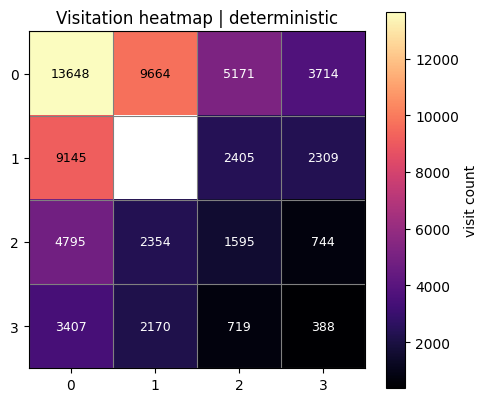

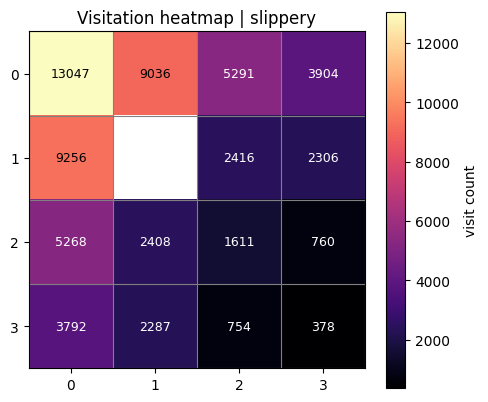

In [8]:
def visitation_counts_random(env: GridWorldEnv, n_episodes: int = 2000, max_steps: int = 200) -> np.ndarray:
    counts = np.zeros(env.nS, dtype=float)

    for _ in range(n_episodes):
        s = env.reset()
        counts[s] += 1
        for _ in range(max_steps):
            a = int(rng.integers(0, env.nA))
            s_next, _, done, _ = env.step(a)
            counts[s_next] += 1
            if done:
                break

    return counts


counts_det = visitation_counts_random(env_det, n_episodes=2000, max_steps=120)
counts_slip = visitation_counts_random(env_slip, n_episodes=2000, max_steps=120)

plot_visitation_heatmap(env_det, counts_det, "Visitation heatmap | deterministic")
plot_visitation_heatmap(env_slip, counts_slip, "Visitation heatmap | slippery")


This visitation heatmap is a baseline diagnostic before optimization. It reveals where random behavior naturally accumulates occupancy, which often corresponds to bottlenecks, dead-ends, or loops in the transition graph. The contrast between regions helps explain why some states become strategically important once VI or PI starts propagating value information.

**Transition sanity probes**

For selected states/actions, inspect the full $p(s', r, done \mid s, a)$ entries.
This validates edge handling, wall collisions, and slip dynamics.


In [9]:
def print_transition_probe(env: GridWorldEnv, state_pos: Tuple[int, int], action: int):
    s = env.pos_to_state[state_pos]
    print(f"Probe at state={s}, pos={state_pos}, action={action} ({ACTION_SYMBOLS[action]})")
    rows = sorted(env.as_mdp().P[s][action], key=lambda x: (-x[0], x[1]))
    for p, s_next, r, done in rows:
        print(f"  p={p:.3f} -> s'={s_next:2d}, pos'={env.state_to_pos[s_next]}, reward={r:5.1f}, done={done}")
    print()


print("Deterministic probes")
print_transition_probe(env_det, (0, 0), RIGHT)
print_transition_probe(env_det, (0, 0), UP)
print_transition_probe(env_det, (1, 0), RIGHT)  # attempts to move into wall at (1,1)

print("Slippery probes")
print_transition_probe(env_slip, (0, 0), RIGHT)
print_transition_probe(env_slip, (1, 0), RIGHT)


Deterministic probes
Probe at state=0, pos=(0, 0), action=1 (→)
  p=1.000 -> s'= 1, pos'=(0, 1), reward= -1.0, done=False

Probe at state=0, pos=(0, 0), action=0 (↑)
  p=1.000 -> s'= 0, pos'=(0, 0), reward= -1.0, done=False

Probe at state=4, pos=(1, 0), action=1 (→)
  p=1.000 -> s'= 4, pos'=(1, 0), reward= -1.0, done=False

Slippery probes
Probe at state=0, pos=(0, 0), action=1 (→)
  p=0.800 -> s'= 1, pos'=(0, 1), reward= -1.0, done=False
  p=0.100 -> s'= 0, pos'=(0, 0), reward= -1.0, done=False
  p=0.100 -> s'= 4, pos'=(1, 0), reward= -1.0, done=False

Probe at state=4, pos=(1, 0), action=1 (→)
  p=0.800 -> s'= 4, pos'=(1, 0), reward= -1.0, done=False
  p=0.100 -> s'= 0, pos'=(0, 0), reward= -1.0, done=False
  p=0.100 -> s'= 7, pos'=(2, 0), reward= -1.0, done=False



**Trajectory visualization**

Plot a single random episode path on top of the grid for debugging and teaching.


Trajectory length=60, return=-60.00, done=False
Saved GIF: assets/web_outputs/random_walk_slippery_fading.gif


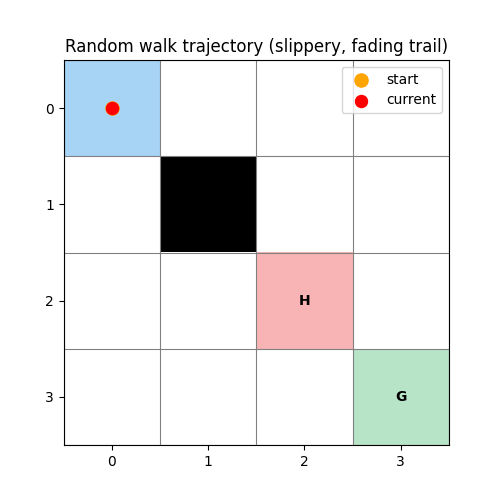

In [10]:
ep = run_random_episode(env_slip, max_steps=60)
print(f"Trajectory length={ep['length']}, return={ep['return']:.2f}, done={ep['done']}")
save_trajectory_gif(
    env_slip,
    ep["states"],
    gif_path=Path("assets/web_outputs/random_walk_slippery_fading.gif"),
    title="Random walk trajectory (slippery, fading trail)",
    fps=6,
    trail_len=18,
    save=True,
)


The trajectory animation makes random exploration dynamics concrete in state space. Instead of only seeing aggregate counts, you can follow how local action noise and map geometry interact step by step. The fading trail keeps temporal order visible while still allowing you to see the most recent motion clearly.

## Value Iteration

In *value iteration*, we start with an arbitrary initial value function and then iteratively improve it until it converges to the optimal value function. At each iteration, we update the value of each state based on the Bellman optimality equation, which states that the value of a state is equal to the immediate reward plus the discounted value of the successor states, weighted by the probability of transitioning to those states under the optimal policy.
The algorithm uses the following update rule:

$$ v_{k+1}(s) = \max_a \sum_{s', r}p(s', r | s, a) [r + \gamma v_k(s')] $$

By repeatedly applying the Bellman optimality equation, the value function converges to the optimal value function in the limit. In practice, we stop when the magnitude of the greatest update, $\delta$ falls below a sufficiently low threshold, $\theta$.
The code below implements value iteration for this problem, and plots out the value function after each iteration.


![Value Iteration Pseudocode](assets/web_outputs/value_iteration.png)

*Sutton & Barto, Chapter 4/5 dynamic programming notation reference used in this session.*


### Task 2

**Implement Value Iteration from Scratch (10-20 min)**

In this task you implement the full Value Iteration algorithm for a tabular MDP. The plotting and experiment cells are already prepared, so this part should focus on the value-update loop and greedy-policy extraction.

Use the Bellman optimality equation as the core update rule:
$$
V_{k+1}(s)=\max_a \sum_{s',r} p(s',r \mid s,a)\left[r+\gamma V_k(s')\right].
$$
A good mental model is to think in two layers: first compute one-step action values from transition dynamics, then take the maximum over actions to update each state value.

During each sweep, compare newly updated values to the previous sweep and track
$$
\delta=\max_s \left|V_{k+1}(s)-V_k(s)\right|.
$$
Stop when `delta < theta` (or when `max_sweeps` is reached). Terminal states should remain fixed and should not be updated like normal states.

After convergence, build the greedy policy from the final value function by recomputing one-step action values and selecting the maximizing action in each non-terminal state. This is important: use the same transition-based action-value logic for policy extraction that you used during value updates, so value and policy stay consistent.

To make downstream cells work, return the full diagnostics package: final `V`, `greedy_actions`, sweep-wise `deltas`, iteration `history` (when requested), and total `sweeps`. If the implementation is correct, you should observe stable convergence and sensible policies on both deterministic and slippery environments.


In [11]:
def bellman_optimality_backup(mdp: TabularMDP, V: np.ndarray, s: int, gamma: float) -> float:
    ########################################################################
    if s in mdp.terminal_states:
        return 0.0

    q_vals = np.zeros(mdp.nA, dtype=float)
    for a in range(mdp.nA):
        for p, s_next, r, done in mdp.P[s][a]:
            q_vals[a] += p * (r + gamma * (0.0 if done else V[s_next]))
    ########################################################################
    return float(np.max(q_vals))

In [12]:

def greedy_actions_from_values(mdp: TabularMDP, V: np.ndarray, gamma: float, theta: float = 1e-10) -> np.ndarray:
    actions = np.zeros(mdp.nS, dtype=int)
    for s in range(mdp.nS):
        if s in mdp.terminal_states:
            actions[s] = 0
            continue

        q_vals = np.zeros(mdp.nA, dtype=float)
        for a in range(mdp.nA):
            for p, s_next, r, done in mdp.P[s][a]:
                q_vals[a] += p * (r + gamma * (0.0 if done else V[s_next]))
        best_q = float(np.max(q_vals))
        best_actions = np.flatnonzero(q_vals >= (best_q - theta))
        actions[s] = int(best_actions[0])
    return actions

In [13]:
def value_iteration(
    mdp: TabularMDP,
    gamma: float = 0.95,
    theta: float = 1e-10,
    max_sweeps: int = 10_000,
    return_history: bool = False,
):
    V = np.zeros(mdp.nS, dtype=float)
    deltas = []
    history = []
    ########################################################################
    for sweep in range(1, max_sweeps + 1):
        V_old = V.copy()
        delta = 0.0

        for s in range(mdp.nS):
            v_new = bellman_optimality_backup(mdp, V_old, s, gamma)
            V[s] = v_new
            delta = max(delta, abs(V[s] - V_old[s]))

        deltas.append(delta)
        if return_history:
            history.append(V.copy())

        if delta < theta:
            break

    ########################################################################
    greedy_actions = greedy_actions_from_values(mdp, V, gamma, theta=theta)
    result = {
        "V": V,
        "greedy_actions": greedy_actions,
        "sweeps": sweep,
        "deltas": deltas,
    }
    if return_history:
        result["history"] = history
    return result

In [14]:
res_det = value_iteration(env_det.as_mdp(), gamma=0.95, theta=1e-10, return_history=True)
res_slip = value_iteration(env_slip.as_mdp(), gamma=0.95, theta=1e-10, return_history=True)

print(f"Deterministic: sweeps={res_det['sweeps']}, final_delta={res_det['deltas'][-1]:.3e}")
print(f"Slippery:      sweeps={res_slip['sweeps']}, final_delta={res_slip['deltas'][-1]:.3e}")


Deterministic: sweeps=7, final_delta=0.000e+00
Slippery:      sweeps=38, final_delta=8.948e-11


**Value Iteration visual diagnostics**

Saved GIF: assets/web_outputs/session2_vi_value_det.gif
Saved GIF: assets/web_outputs/session2_vi_value_slip.gif


Saved PNG: assets/web_outputs/session2_vi_convergence_pair.png


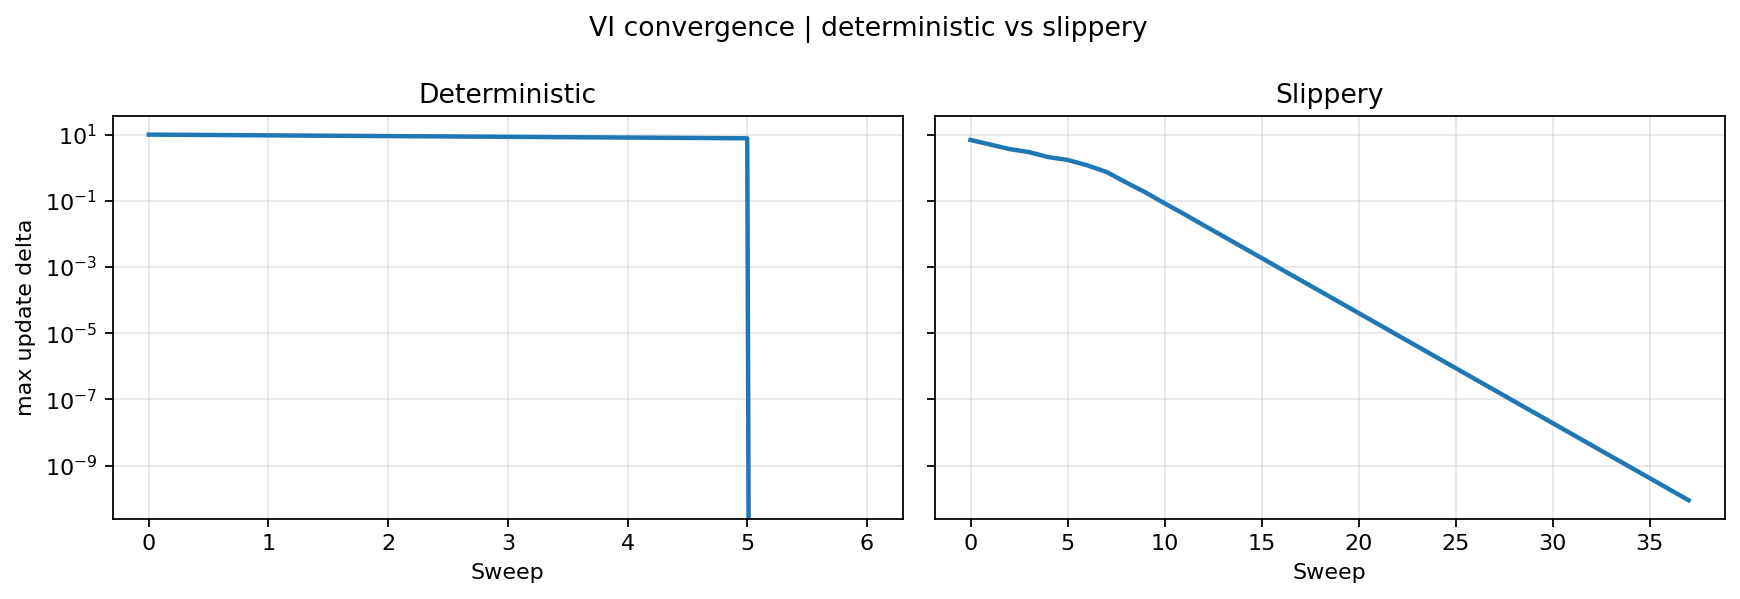

In [15]:
mdp_det = env_det.as_mdp()
mdp_slip = env_slip.as_mdp()

try:
    out_dir = Path("assets/web_outputs")
    out_dir.mkdir(parents=True, exist_ok=True)

    # # 1) Final value tables (numbers in cells), side by side
    # plot_value_pair(
    #     mdp_det,
    #     res_det["V"],
    #     "VI final values | deterministic",
    #     mdp_slip,
    #     res_slip["V"],
    #     "VI final values | slippery",
    #     save=True,
    #     png_path=out_dir / "session2_vi_values_pair.png",
    # )

    # 2) Only two VI evolution GIFs
    vi_gif_det = out_dir / "session2_vi_value_det.gif"
    vi_gif_slip = out_dir / "session2_vi_value_slip.gif"

    save_vi_value_gif(
        mdp_det,
        res_det["history"],
        gif_path=vi_gif_det,
        title_prefix="VI value evolution (deterministic)",
        save=True,
        showcase=False,
    )
    save_vi_value_gif(
        mdp_slip,
        res_slip["history"],
        gif_path=vi_gif_slip,
        title_prefix="VI value evolution (slippery)",
        save=True,
        showcase=False,
    )
    _display_media_row([vi_gif_det, vi_gif_slip], width_px=430)

    # 3) Convergence plots side by side
    plot_vi_convergence_pair(
        res_det["deltas"],
        res_slip["deltas"],
        save=True,
        png_path=out_dir / "session2_vi_convergence_pair.png",
        title="VI convergence | deterministic vs slippery",
    )

except Exception as e:
    print(f"VI showcase export skipped: {e}")

These outputs summarize Value Iteration on deterministic and slippery dynamics in one aligned view. The value-evolution GIFs show how rewards propagate backward through reachable states as Bellman backups iterate, while the side-by-side convergence plot shows the computational impact of uncertainty. Together they connect algorithm mechanics, final values, and runtime behavior.

### Value Iteration example: greedy-policy rollouts

We execute episodes with the greedy policy returned by Value Iteration to inspect behavior, not only value tables.


In [16]:
def rollout_with_greedy_actions(env: GridWorldEnv, greedy_actions: np.ndarray, max_steps: int = 100):
    s = env.reset()
    states = [s]
    rewards = []
    done = False

    for _ in range(max_steps):
        a = int(greedy_actions[s])
        s_next, r, done, _ = env.step(a)
        states.append(s_next)
        rewards.append(r)
        s = s_next
        if done:
            break

    return {
        "states": states,
        "return": float(np.sum(rewards)),
        "length": len(rewards),
        "done": done,
        "terminal_state": states[-1],
    }


In [17]:


def evaluate_greedy_policy(env: GridWorldEnv, greedy_actions: np.ndarray, n_episodes: int = 200):
    returns = []
    success = 0

    for _ in range(n_episodes):
        ep = rollout_with_greedy_actions(env, greedy_actions, max_steps=120)
        returns.append(ep["return"])
        if ep["done"]:
            r, c = env.state_to_pos[ep["terminal_state"]]
            if env.grid[r, c] == "G":
                success += 1

    return float(np.mean(returns)), success / n_episodes


mean_ret_det, succ_det = evaluate_greedy_policy(env_det, res_det["greedy_actions"], n_episodes=200)
mean_ret_slip, succ_slip = evaluate_greedy_policy(env_slip, res_slip["greedy_actions"], n_episodes=200)

print(f"Deterministic greedy policy: mean_return={mean_ret_det:.3f}, success_rate={succ_det*100:.1f}%")
print(f"Slippery greedy policy:      mean_return={mean_ret_slip:.3f}, success_rate={succ_slip*100:.1f}%")

ep_det = rollout_with_greedy_actions(env_det, res_det["greedy_actions"], max_steps=60)
ep_slip = rollout_with_greedy_actions(env_slip, res_slip["greedy_actions"], max_steps=60)


try:
    out_dir = Path("assets/web_outputs")
    gif_det = out_dir / "session2_vi_greedy_traj_det.gif"
    gif_slip = out_dir / "session2_vi_greedy_traj_slip.gif"

    save_trajectory_gif(
        env_det,
        ep_det["states"],
        gif_path=gif_det,
        title="Greedy rollout evolution (deterministic)",
        save=True,
        showcase=False,
    )
    save_trajectory_gif(
        env_slip,
        ep_slip["states"],
        gif_path=gif_slip,
        title="Greedy rollout evolution (slippery)",
        save=True,
        showcase=False,
    )

    _display_media_row([gif_det, gif_slip], width_px=430)

except Exception as e:
    print(f"VI trajectory GIF export skipped: {e}")

Deterministic greedy policy: mean_return=5.000, success_rate=100.0%
Slippery greedy policy:      mean_return=0.945, success_rate=86.0%
Saved GIF: assets/web_outputs/session2_vi_greedy_traj_det.gif
Saved GIF: assets/web_outputs/session2_vi_greedy_traj_slip.gif


**Value Iteration experiment A: `gamma` sensitivity**

This experiment shows how the discount factor $\gamma$ changes the agent’s notion of “good.” In practice, $\gamma$ is what decides whether the policy prefers short-term gains or is willing to sacrifice immediate reward for better long-term outcomes. That is why this is not just a tuning detail: different $\gamma$ values can produce genuinely different behaviors, especially in maps where the shortest path is also riskier.

We track convergence sweeps, the value of the start state, and policy changes across $\gamma$ values. Together, these reveal both the behavioral effect (what the agent chooses) and the computational effect (how hard the planning problem is).

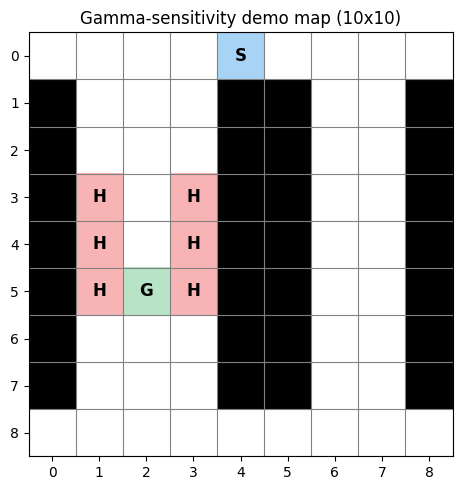

Transition model sanity check passed (all action distributions sum to 1).
nS=53, nA=4, start=4, terminals=[19, 21, 24, 26, 29, 30, 31]


In [18]:
# Gamma-sensitivity showcase map:
# short risky route near holes vs longer safer detour
gamma_sensitive_map_10x10 = [
    "....S....",
    "#...##..#",
    "#...##..#",
    "#H.H##..#",
    "#H.H##..#",
    "#HGH##..#",
    "#...##..#",
    "#...##..#",
    ".........",
]

cfg_gamma_demo = GridWorldConfig(
    char_map=gamma_sensitive_map_10x10,
    step_reward=-0.2,
    goal_reward=10.0,
    hole_reward=-12.0,
    slip_prob=0.15,
)

env_gamma_demo = GridWorldEnv(cfg_gamma_demo)
mdp_gamma_demo = env_gamma_demo.as_mdp()

render_map(env_gamma_demo, title="Gamma-sensitivity demo map (10x10)")
validate_transition_model(mdp_gamma_demo)

print(
    f"nS={mdp_gamma_demo.nS}, nA={mdp_gamma_demo.nA}, "
    f"start={mdp_gamma_demo.start_state}, terminals={sorted(mdp_gamma_demo.terminal_states)}"
)


This map is intentionally structured to contain meaningful route trade-offs rather than one obviously dominant shortest path. Because of that, changing the discount factor can alter whether the policy prefers immediate local safety or delayed global reward. It is a better probe for gamma sensitivity than a trivial corridor map.

gamma | sweeps | V(start)
0.70 |     39 |   -0.360
0.85 |     52 |    0.153
0.95 |     74 |    1.282
0.99 |     90 |    4.392

Policy agreement vs gamma=0.95
gamma=0.70 -> agreement= 80.43%
gamma=0.85 -> agreement= 86.96%
gamma=0.95 -> agreement=100.00%
gamma=0.99 -> agreement= 89.13%


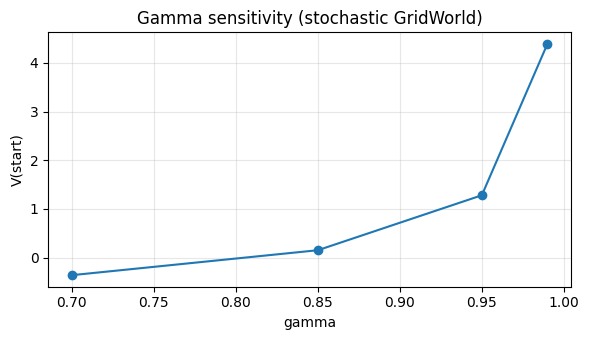

In [19]:
def compare_policies(actions_a: np.ndarray, actions_b: np.ndarray, terminal_states: set) -> float:
    mask = np.ones_like(actions_a, dtype=bool)
    for s in terminal_states:
        mask[s] = False
    return float(np.mean(actions_a[mask] == actions_b[mask]))


gammas = [0.70, 0.85, 0.95, 0.99]
rows = []
policies = {}

for g in gammas:
    out = value_iteration(mdp_gamma_demo, gamma=g, theta=1e-10, return_history=False)
    s0 = mdp_gamma_demo.start_state
    rows.append((g, out["sweeps"], out["V"][s0]))
    policies[g] = out["greedy_actions"]

print("gamma | sweeps | V(start)")
for g, sw, vs in rows:
    print(f"{g:4.2f} | {sw:6d} | {vs:8.3f}")

print("\nPolicy agreement vs gamma=0.95")
base = policies[0.95]
for g in gammas:
    agree = compare_policies(base, policies[g], mdp_gamma_demo.terminal_states)
    print(f"gamma={g:4.2f} -> agreement={agree*100:6.2f}%")

plt.figure(figsize=(6, 3.5))
plt.plot([r[0] for r in rows], [r[2] for r in rows], marker="o")
plt.xlabel("gamma")
plt.ylabel("V(start)")
plt.title("Gamma sensitivity (stochastic GridWorld)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [20]:
# Low-vs-high gamma behavior showcase (trajectory GIF pair)
try:
    out_dir = Path("assets/web_outputs")
    out_dir.mkdir(parents=True, exist_ok=True)

    g_low, g_high = 0.7, 0.99
    vi_low = value_iteration(mdp_gamma_demo, gamma=g_low, theta=1e-10, return_history=False)
    vi_high = value_iteration(mdp_gamma_demo, gamma=g_high, theta=1e-10, return_history=False)

    ep_low = rollout_with_greedy_actions(env_gamma_demo, vi_low["greedy_actions"], max_steps=180)
    ep_high = rollout_with_greedy_actions(env_gamma_demo, vi_high["greedy_actions"], max_steps=180)

    gif_low = out_dir / "session2_gamma_low_traj.gif"
    gif_high = out_dir / "session2_gamma_high_traj.gif"

    save_trajectory_gif(
        env_gamma_demo,
        ep_low["states"],
        gif_path=gif_low,
        title=f"Greedy rollout | gamma={g_low:.2f}",
        trail_len=22,
        save=True,
        showcase=False,
    )
    save_trajectory_gif(
        env_gamma_demo,
        ep_high["states"],
        gif_path=gif_high,
        title=f"Greedy rollout | gamma={g_high:.2f}",
        trail_len=22,
        save=True,
        showcase=False,
    )

    print(f"gamma={g_low:.2f}: return={ep_low['return']:.3f}, length={ep_low['length']}, done={ep_low['done']}")
    print(f"gamma={g_high:.2f}: return={ep_high['return']:.3f}, length={ep_high['length']}, done={ep_high['done']}")

    _display_media_row([gif_low, gif_high], width_px=430)

except Exception as e:
    print(f"Gamma rollout GIF showcase skipped: {e}")

Saved GIF: assets/web_outputs/session2_gamma_low_traj.gif
Saved GIF: assets/web_outputs/session2_gamma_high_traj.gif
gamma=0.70: return=-14.000, length=11, done=True
gamma=0.99: return=5.600, length=23, done=True


As gamma changes, both the optimization target and the planning dynamics change. The start-state value captures how strongly the agent values delayed outcomes, while agreement scores quantify whether the policy structure itself is robust or shifts across settings. Looking at both is essential: similar values can still hide different action choices, and vice versa.

Policy agreement is not 100% across all settings, so the map is now expressing real decision trade-offs. In other words, changing $\gamma$ changes what the agent considers optimal, not just the numeric value scale. That is exactly what we wanted from this experiment.

The start-state value trend is also informative: the value is worst around intermediate-high $\gamma$ here, then improves again at $\gamma=0.99$, which suggests the objective is balancing longer-horizon gains against increased exposure to per-step penalties and stochastic risk in a nontrivial way. The relationship is not monotonic, and that is normal on maps with competing routes and slip dynamics.

Sweep counts vary substantially, which confirms the computational effect too: different $\gamma$ values induce different convergence behavior. The key takeaway is that $\gamma$ is not a cosmetic hyperparameter; it changes both policy structure and optimization difficulty on this map.

**Value Iteration experiment B: `theta` (stopping threshold) sensitivity**

This experiment focuses on the practical convergence trade-off in Value Iteration. The threshold $\theta$ decides when we stop iterating: a larger $\theta$ stops earlier with a rougher approximation, while a smaller $\theta$ pushes for a more precise value function but costs more computation. In real work, this is one of the key knobs for balancing speed and solution quality.

We compare sweep count, runtime, and accuracy against a strict reference solution. This makes it clear where extra computation still improves the result and where it mostly adds cost without meaningful policy benefit.  



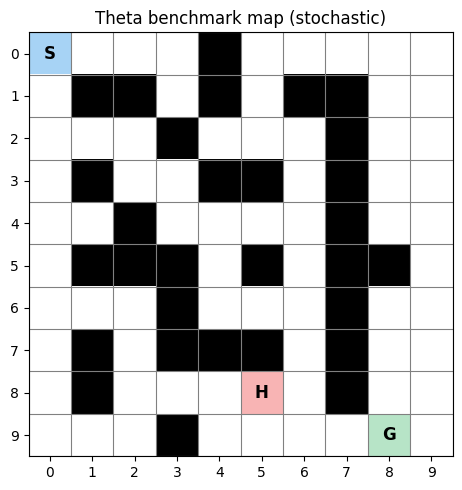

theta demo: nS=70, nA=4, start=0, terminals=[57, 68]


In [21]:
# Theta-sensitivity benchmark map (stochastic + long-horizon to make theta matter)
theta_benchmark_map_10x10 = [
    "S...#.....",
    ".##.#.##..",
    "...#...#..",
    ".#..##.#..",
    "..#....#..",
    ".###.#.##.",
    "...#...#..",
    ".#.###.#..",
    ".#...H.#..",
    "...#....G.",
]

cfg_theta_demo = GridWorldConfig(
    char_map=theta_benchmark_map_10x10,
    step_reward=-0.01,
    goal_reward=1.0,
    hole_reward=-1.0,
    slip_prob=0.20,   # stochastic transitions -> smoother convergence, theta has visible effect
)

env_theta_demo = GridWorldEnv(cfg_theta_demo)
mdp_theta_demo = env_theta_demo.as_mdp()

render_map(env_theta_demo, title="Theta benchmark map (stochastic)")
print(
    f"theta demo: nS={mdp_theta_demo.nS}, nA={mdp_theta_demo.nA}, "
    f"start={mdp_theta_demo.start_state}, terminals={sorted(mdp_theta_demo.terminal_states)}"
)


This benchmark map is used to isolate stopping-threshold behavior from unrelated sources of variation. By controlling map structure and reward scale, theta can be interpreted primarily as a numerical-precision knob. That makes runtime and value-error differences more meaningful and easier to compare across runs.

theta | sweeps | runtime_ms | L_inf_to_ref
1e-04 |     72 |     15.698 |   9.889e-04
1e-06 |    123 |     27.206 |   9.857e-06
1e-08 |    174 |     37.625 |   9.824e-08
1e-10 |    225 |     48.761 |   9.695e-10


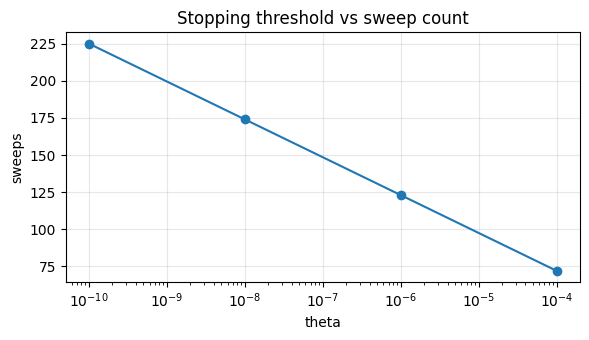

In [22]:
thetas = [1e-4, 1e-6, 1e-8, 1e-10]
ref = value_iteration(mdp_theta_demo, gamma=0.99, theta=1e-12, return_history=False)
V_ref = ref["V"]

results = []
for th in thetas:
    t0 = time.perf_counter()
    out = value_iteration(mdp_theta_demo, gamma=0.99, theta=th, return_history=False)
    dt_ms = (time.perf_counter() - t0) * 1e3
    linf = float(np.max(np.abs(out["V"] - V_ref)))
    results.append((th, out["sweeps"], dt_ms, linf))

print("theta | sweeps | runtime_ms | L_inf_to_ref")
for th, sw, dt, linf in results:
    print(f"{th:>5.0e} | {sw:6d} | {dt:10.3f} | {linf:11.3e}")

plt.figure(figsize=(6, 3.5))
plt.plot([r[0] for r in results], [r[1] for r in results], marker="o")
plt.xscale("log")
plt.xlabel("theta")
plt.ylabel("sweeps")
plt.title("Stopping threshold vs sweep count")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


This table and plot quantify the core practical trade-off behind theta. A smaller threshold keeps iterative updates running until finer residual errors are removed, which usually improves approximation quality relative to a strict reference solution. The cost is increased sweeps and runtime, so this experiment helps choose a threshold that is precise enough without overcomputing.

If runtime and sweeps rise sharply as $\theta$ gets smaller but policy changes are minimal, you are already in a “good enough” regime at a looser threshold. If both value error and policy behavior still change noticeably, tighter convergence is justified. The point of this experiment is to identify a threshold that is accurate enough for decision quality without overpaying in computation.

These rollout GIFs validate that the VI policy is not only numerically optimal in value tables but also behaviorally coherent when executed. Seeing deterministic and slippery trajectories side by side makes risk handling visible: one path is crisp, the other may include corrective motion under stochastic transitions. This closes the loop between planning outputs and actual control behavior.

## Policy Evaluation + Policy Iteration

### Short theory recap (Sutton & Barto, Ch. 4)

Policy Iteration alternates between two operators:

1. **Policy Evaluation**: compute $V^{\pi}$ for the current policy $\pi$.
2. **Policy Improvement**: update policy greedily with respect to the evaluated value function.

Policy evaluation uses the Bellman expectation equation:
$$
V^{\pi}(s)=\sum_a \pi(a\mid s)\sum_{s',r}p(s',r\mid s,a)\left[r+\gamma V^{\pi}(s')\right]
$$

Policy improvement is greedy:
$$
\pi_{new}(s)\in\argmax_a \sum_{s',r}p(s',r\mid s,a)\left[r+\gamma V^{\pi}(s')\right]
$$

With finite tabular MDPs, repeated evaluation + improvement converges to an optimal policy.


![Policy Iteration Pseudocode](assets/web_outputs/policy_iteration.png)

*Sutton & Barto policy evaluation and policy improvement loop reference used in this section.*


### Task 3

**Implement Policy Iteration (10-20 min)**

In this task you implement Policy Iteration as an outer loop with two alternating phases: evaluate the current policy, then improve it greedily. The loop stops when improvement no longer changes the policy.

For policy evaluation, keep the policy fixed and repeatedly update values using expected returns under $\pi$:
$$
V^{\pi}(s)=\sum_a \pi(a\mid s)\sum_{s',r} p(s',r\mid s,a)\left[r+\gamma V^{\pi}(s')\right].
$$
Use sweep-based updates, track the maximum per-sweep change
$$
\delta=\max_s \left|V_{\text{new}}(s)-V_{\text{old}}(s)\right|,
$$
and stop evaluation when `delta < eval_theta`. Terminal states should remain fixed and should not be treated like normal update states.

For policy improvement, compute one-step action values from the evaluated `V` and build a greedy policy:
$$
q(s,a)=\sum_{s',r} p(s',r\mid s,a)\left[r+\gamma V(s')\right],\qquad
\pi_{\text{new}}(s)\in\arg\max_a q(s,a).
$$
You can compare stability by checking whether the greedy action index in each state changed between old and improved policies. If no greedy action changes, the policy is stable and the algorithm terminates.

Implementation guidance:
- Initialize with a valid policy (uniform over actions is fine).
- In each outer iteration, call policy evaluation first, then policy improvement.
- Store evaluation diagnostics per outer loop (`eval_sweeps`, `eval_deltas`) so convergence plots can be generated later.
- If `return_history=True`, store snapshots (`outer`, `V`, `policy`, `stable`) for GIF/visual diagnostics.

Expected behavior:
- Deterministic maps usually need fewer evaluation sweeps and outer loops than slippery maps.
- Final PI policy should be consistent with VI on the same MDP and hyperparameters (or very close up to ties).
- Returned structure should include at least `policy`, `V`, `outer_loops`, `eval_sweeps`, and `eval_delta_curves` so downstream cells run without edits.


In [23]:
def greedy_policy_from_values(mdp: TabularMDP, V: np.ndarray, gamma: float = 0.95, theta: float = 1e-10) -> np.ndarray:
    policy = np.zeros((mdp.nS, mdp.nA), dtype=float)

    for s in range(mdp.nS):
        if s in mdp.terminal_states:
            policy[s, :] = 1.0 / mdp.nA
            continue

        q_vals = np.zeros(mdp.nA, dtype=float)
        for a in range(mdp.nA):
            for p, s_next, r, done in mdp.P[s][a]:
                q_vals[a] += p * (r + gamma * (0.0 if done else V[s_next]))

        best_q = float(np.max(q_vals))
        best_actions = np.flatnonzero(q_vals >= (best_q - theta))
        best_a = int(best_actions[0])
        policy[s, best_a] = 1.0

    return policy


In [24]:
def policy_evaluation(
    mdp: TabularMDP,
    policy: np.ndarray,
    gamma: float = 0.95,
    theta: float = 1e-10,
    max_sweeps: int = 50_000,
):
    V = np.zeros(mdp.nS, dtype=float)
    deltas = []
    ########################################################################
    for sweep in range(1, max_sweeps + 1):
        V_old = V.copy()
        delta = 0.0

        for s in range(mdp.nS):
            if s in mdp.terminal_states:
                V[s] = 0.0
                continue

            v_new = 0.0
            for a in range(mdp.nA):
                pi_sa = policy[s, a]
                if pi_sa == 0.0:
                    continue
                for p, s_next, r, done in mdp.P[s][a]:
                    v_new += pi_sa * p * (r + gamma * (0.0 if done else V_old[s_next]))

            V[s] = v_new
            delta = max(delta, abs(V[s] - V_old[s]))

        deltas.append(delta)
        if delta < theta:
            return V, sweep, deltas
    ########################################################################
    return V, max_sweeps, deltas

In [25]:
def policy_iteration(
    mdp: TabularMDP,
    gamma: float = 0.95,
    eval_theta: float = 1e-10,
    max_outer_loops: int = 1_000,
    return_history: bool = False,
):
    policy = np.ones((mdp.nS, mdp.nA), dtype=float) / mdp.nA

    history = []
    eval_sweeps_list = []
    eval_delta_curves = []
    ########################################################################
    for outer in range(1, max_outer_loops + 1):
        V, eval_sweeps, eval_deltas = policy_evaluation(
            mdp,
            policy,
            gamma=gamma,
            theta=eval_theta,
        )

        eval_sweeps_list.append(eval_sweeps)
        eval_delta_curves.append(eval_deltas)

        improved_policy = greedy_policy_from_values(mdp, V, gamma=gamma, theta=eval_theta)

        stable = np.array_equal(np.argmax(policy, axis=1), np.argmax(improved_policy, axis=1))
    ########################################################################
        if return_history:
            history.append(
                {
                    "outer": outer,
                    "V": V.copy(),
                    "policy": improved_policy.copy(),
                    "eval_sweeps": eval_sweeps,
                    "eval_deltas": eval_deltas,
                    "stable": stable,
                }
            )

        policy = improved_policy
        if stable:
            break

    result = {
        "policy": policy,
        "V": V,
        "outer_loops": outer,
        "eval_sweeps": eval_sweeps_list,
        "eval_delta_curves": eval_delta_curves,
    }
    if return_history:
        result["history"] = history
    return result

In [26]:
pi_det = policy_iteration(mdp_det, gamma=0.95, eval_theta=1e-10, return_history=True)
pi_slip = policy_iteration(mdp_slip, gamma=0.95, eval_theta=1e-10, return_history=True)

print(f"Policy Iteration (deterministic): outer_loops={pi_det['outer_loops']}, eval_sweeps_total={sum(pi_det['eval_sweeps'])}")
print(f"Policy Iteration (slippery):      outer_loops={pi_slip['outer_loops']}, eval_sweeps_total={sum(pi_slip['eval_sweeps'])}")

Policy Iteration (deterministic): outer_loops=4, eval_sweeps_total=262
Policy Iteration (slippery):      outer_loops=3, eval_sweeps_total=310


### Policy Iteration visual diagnostics

This section mirrors the Value Iteration diagnostics with a compact Policy Iteration view:
1. PI evolution GIFs for deterministic and slippery settings (side by side),
2. greedy action arrows overlaid at each outer iteration,
3. PI convergence plots shown as a matched pair below.

Using the same save-and-display flow as VI keeps the comparison clean and consistent.

### Policy Iteration snapshots and GIF

We capture intermediate policies and values across outer loops to show how policy improvement progresses.


Saved GIF: assets/web_outputs/session2_pi_evolution_det.gif
Saved GIF: assets/web_outputs/session2_pi_evolution_slip.gif


Saved PNG: assets/web_outputs/session2_pi_convergence_pair.png


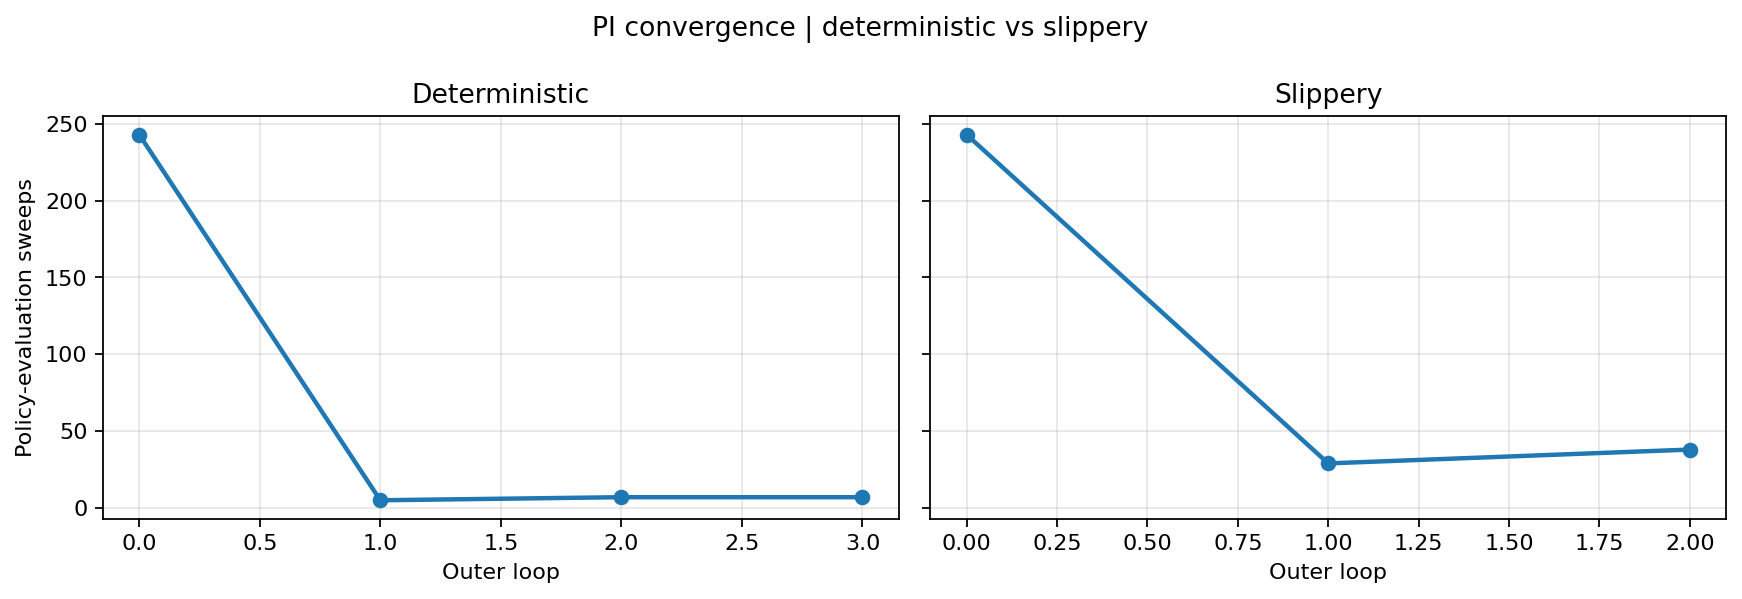

In [27]:
def save_policy_iteration_gif(
    mdp: TabularMDP,
    history: list,
    gif_path: Path | None = None,
    title_prefix: str = "Policy Iteration",
    save: bool = False,
    fps: int = 2,
    showcase: bool = True,
):
    if not history:
        print("No history available; GIF was not created.")
        return

    value_grids = [values_to_grid(mdp, h["V"]) for h in history]
    action_grids = []
    for h in history:
        a = np.argmax(h["policy"], axis=1)
        g = np.full(mdp.grid_chars.shape, -1, dtype=int)
        for s, (r, c) in mdp.state_to_pos.items():
            if mdp.grid_chars[r, c] not in ("G", "H"):
                g[r, c] = a[s]
        action_grids.append(g)

    vec = {
        UP: (0.0, -0.35),
        RIGHT: (0.35, 0.0),
        DOWN: (0.0, 0.35),
        LEFT: (-0.35, 0.0),
    }

    fig, ax = plt.subplots(figsize=(5, 5))
    im = ax.imshow(value_grids[0], cmap="viridis")
    txt = ax.set_title(f"{title_prefix} | outer=1")
    ax.set_xticks(range(value_grids[0].shape[1]))
    ax.set_yticks(range(value_grids[0].shape[0]))
    _draw_cell_grid(ax, value_grids[0].shape[0], value_grids[0].shape[1])

    q = None

    def update(frame_idx):
        nonlocal q
        im.set_data(value_grids[frame_idx])

        if q is not None:
            q.remove()

        actions = action_grids[frame_idx]
        X, Y, U, V = [], [], [], []
        for r in range(actions.shape[0]):
            for c in range(actions.shape[1]):
                if mdp.grid_chars[r, c] in ("#", "G", "H"):
                    continue
                a = actions[r, c]
                if a < 0:
                    continue
                u, v = vec[a]
                X.append(c)
                Y.append(r)
                U.append(u)
                V.append(v)

        if X:
            q = ax.quiver(X, Y, U, V, angles="xy", scale_units="xy", scale=1, color="white", width=0.008)

        outer = history[frame_idx]["outer"]
        txt.set_text(f"{title_prefix} | outer={outer}")
        return im, txt

    ani = FuncAnimation(fig, update, frames=len(history), interval=550, blit=False)
    _finalize_gif_animation(ani, fig, save=save, gif_path=gif_path, fps=fps, showcase=showcase)


try:
    out_dir = Path("assets/web_outputs")
    out_dir.mkdir(parents=True, exist_ok=True)

    pi_gif_det = out_dir / "session2_pi_evolution_det.gif"
    pi_gif_slip = out_dir / "session2_pi_evolution_slip.gif"

    save_policy_iteration_gif(
        mdp_det,
        pi_det["history"],
        pi_gif_det,
        title_prefix="Policy Iteration deterministic",
        save=True,
        showcase=False,
    )
    save_policy_iteration_gif(
        mdp_slip,
        pi_slip["history"],
        pi_gif_slip,
        title_prefix="Policy Iteration slippery",
        save=True,
        showcase=False,
    )
    _display_media_row([pi_gif_det, pi_gif_slip], width_px=430)

    plot_pi_convergence_pair(
        pi_det,
        pi_slip,
        save=True,
        png_path=out_dir / "session2_pi_convergence_pair.png",
        title="PI convergence | deterministic vs slippery",
    )
except Exception as e:
    print(f"PI GIF export skipped: {e}")

Policy Iteration is shown in the same visual format as Value Iteration so the comparison stays fair and readable. The evolution GIFs emphasize policy-improvement steps over outer iterations, while convergence panels show policy-evaluation effort per iteration. This helps distinguish algorithmic behavior from environment effects.

### Policy Iteration example: greedy-policy rollouts

We run episodes with the final PI policy in deterministic and slippery environments.


In [28]:
pi_actions_det = np.argmax(pi_det["policy"], axis=1)
pi_actions_slip = np.argmax(pi_slip["policy"], axis=1)

mean_ret_det_pi, succ_det_pi = evaluate_greedy_policy(env_det, pi_actions_det, n_episodes=200)
mean_ret_slip_pi, succ_slip_pi = evaluate_greedy_policy(env_slip, pi_actions_slip, n_episodes=200)

print(f"PI deterministic policy: mean_return={mean_ret_det_pi:.3f}, success_rate={succ_det_pi*100:.1f}%")
print(f"PI slippery policy:      mean_return={mean_ret_slip_pi:.3f}, success_rate={succ_slip_pi*100:.1f}%")

ep_det_pi = rollout_with_greedy_actions(env_det, pi_actions_det, max_steps=60)
ep_slip_pi = rollout_with_greedy_actions(env_slip, pi_actions_slip, max_steps=60)

try:
    out_dir = Path("assets/web_outputs")
    gif_det = out_dir / "session2_pi_greedy_traj_det.gif"
    gif_slip = out_dir / "session2_pi_greedy_traj_slip.gif"

    save_trajectory_gif(
        env_det,
        ep_det_pi["states"],
        gif_det,
        title="Greedy rollout evolution (PI deterministic)",
        save=True,
        showcase=False,
    )
    save_trajectory_gif(
        env_slip,
        ep_slip_pi["states"],
        gif_slip,
        title="Greedy rollout evolution (PI slippery)",
        save=True,
        showcase=False,
    )

    _display_media_row([gif_det, gif_slip], width_px=430)

except Exception as e:
    print(f"PI trajectory GIF export skipped: {e}")

PI deterministic policy: mean_return=5.000, success_rate=100.0%
PI slippery policy:      mean_return=1.495, success_rate=89.5%
Saved GIF: assets/web_outputs/session2_pi_greedy_traj_det.gif
Saved GIF: assets/web_outputs/session2_pi_greedy_traj_slip.gif


### Policy Iteration experiment A: `gamma` sensitivity

What we analyze:
- number of outer loops,
- total policy-evaluation sweeps,
- value at the start state,
- policy agreement relative to $\gamma=0.95$.


gamma | outer_loops | eval_sweeps_total | V(start)
0.70 |           9 |               492 |   -0.360
0.85 |          10 |               934 |    0.153
0.95 |          12 |              2547 |    1.282
0.99 |          11 |              2334 |    4.392

Policy agreement vs gamma=0.95
gamma=0.70 -> agreement= 80.43%
gamma=0.85 -> agreement= 86.96%
gamma=0.95 -> agreement=100.00%
gamma=0.99 -> agreement= 89.13%


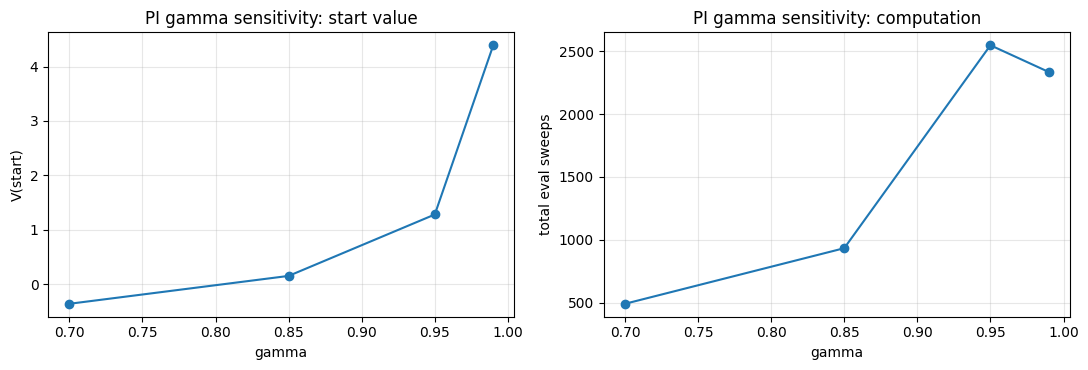

In [29]:
# Use the same gamma-sensitive map as in Value Iteration for fair comparison
gammas_pi = [0.70, 0.85, 0.95, 0.99]
rows_pi = []
policies_pi = {}

for g in gammas_pi:
    out = policy_iteration(mdp_gamma_demo, gamma=g, eval_theta=1e-10, return_history=False)
    start_v = out["V"][mdp_gamma_demo.start_state]
    rows_pi.append((g, out["outer_loops"], int(sum(out["eval_sweeps"])), start_v))
    policies_pi[g] = np.argmax(out["policy"], axis=1)

print("gamma | outer_loops | eval_sweeps_total | V(start)")
for g, ol, es, vs in rows_pi:
    print(f"{g:4.2f} | {ol:11d} | {es:17d} | {vs:8.3f}")

print("\nPolicy agreement vs gamma=0.95")
base = policies_pi[0.95]
for g in gammas_pi:
    agree = compare_policies(base, policies_pi[g], mdp_gamma_demo.terminal_states)
    print(f"gamma={g:4.2f} -> agreement={agree*100:6.2f}%")

fig, axes = plt.subplots(1, 2, figsize=(11, 3.8))

axes[0].plot([r[0] for r in rows_pi], [r[3] for r in rows_pi], marker="o")
axes[0].set_xlabel("gamma")
axes[0].set_ylabel("V(start)")
axes[0].set_title("PI gamma sensitivity: start value")
axes[0].grid(True, alpha=0.3)

axes[1].plot([r[0] for r in rows_pi], [r[2] for r in rows_pi], marker="o")
axes[1].set_xlabel("gamma")
axes[1].set_ylabel("total eval sweeps")
axes[1].set_title("PI gamma sensitivity: computation")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Running PI gamma sensitivity on exactly the same map used for VI removes a major confound in interpretation. If behavior differs, that difference is much more likely due to algorithmic update structure rather than environment design. This is the right setup for a method-level comparison in class.

In [30]:

# Low-vs-high gamma behavior showcase for Policy Iteration (trajectory GIF pair)
try:
    out_dir = Path("assets/web_outputs")
    out_dir.mkdir(parents=True, exist_ok=True)

    g_low, g_high = 0.70, 0.99
    pi_low = policy_iteration(mdp_gamma_demo, gamma=g_low, eval_theta=1e-10, return_history=False)
    pi_high = policy_iteration(mdp_gamma_demo, gamma=g_high, eval_theta=1e-10, return_history=False)

    actions_low = np.argmax(pi_low["policy"], axis=1)
    actions_high = np.argmax(pi_high["policy"], axis=1)

    ep_low = rollout_with_greedy_actions(env_gamma_demo, actions_low, max_steps=180)
    ep_high = rollout_with_greedy_actions(env_gamma_demo, actions_high, max_steps=180)

    gif_low = out_dir / "session2_pi_gamma_low_traj.gif"
    gif_high = out_dir / "session2_pi_gamma_high_traj.gif"

    save_trajectory_gif(
        env_gamma_demo,
        ep_low["states"],
        gif_path=gif_low,
        title=f"PI greedy rollout | gamma={g_low:.2f}",
        trail_len=22,
        save=True,
        showcase=False,
    )
    save_trajectory_gif(
        env_gamma_demo,
        ep_high["states"],
        gif_path=gif_high,
        title=f"PI greedy rollout | gamma={g_high:.2f}",
        trail_len=22,
        save=True,
        showcase=False,
    )

    print(f"gamma={g_low:.2f}: return={ep_low['return']:.3f}, length={ep_low['length']}, done={ep_low['done']}")
    print(f"gamma={g_high:.2f}: return={ep_high['return']:.3f}, length={ep_high['length']}, done={ep_high['done']}")

    _display_media_row([gif_low, gif_high], width_px=430)

except Exception as e:
    print(f"PI gamma rollout GIF showcase skipped: {e}")


Saved GIF: assets/web_outputs/session2_pi_gamma_low_traj.gif
Saved GIF: assets/web_outputs/session2_pi_gamma_high_traj.gif
gamma=0.70: return=8.800, length=7, done=True
gamma=0.99: return=5.800, length=22, done=True


### Policy Iteration experiment B: evaluation-threshold sensitivity

What we analyze:
- how `eval_theta` affects computational effort,
- whether the final greedy policy changes.


eval_theta | outer_loops | eval_sweeps_total
    1e-04 |           4 |               121
    1e-06 |           4 |               168
    1e-08 |           4 |               215
    1e-10 |           4 |               262

Policy agreement vs eval_theta=1e-10
eval_theta=    1e-04 -> agreement=100.00%
eval_theta=    1e-06 -> agreement=100.00%
eval_theta=    1e-08 -> agreement=100.00%
eval_theta=    1e-10 -> agreement=100.00%


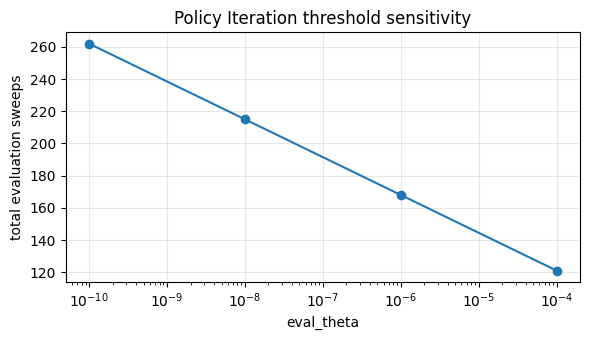

In [31]:
eval_thetas = [1e-4, 1e-6, 1e-8, 1e-10]
rows_theta = []
pol_by_theta = {}

for th in eval_thetas:
    out = policy_iteration(mdp_det, gamma=0.95, eval_theta=th, return_history=False)
    actions = np.argmax(out["policy"], axis=1)
    rows_theta.append((th, out["outer_loops"], int(sum(out["eval_sweeps"]))))
    pol_by_theta[th] = actions

print("eval_theta | outer_loops | eval_sweeps_total")
for th, ol, es in rows_theta:
    print(f"{th:>9.0e} | {ol:11d} | {es:17d}")

base = pol_by_theta[1e-10]
print("\nPolicy agreement vs eval_theta=1e-10")
for th in eval_thetas:
    agree = compare_policies(base, pol_by_theta[th], mdp_det.terminal_states)
    print(f"eval_theta={th:>9.0e} -> agreement={agree*100:6.2f}%")

plt.figure(figsize=(6, 3.5))
plt.plot([r[0] for r in rows_theta], [r[2] for r in rows_theta], marker="o")
plt.xscale("log")
plt.xlabel("eval_theta")
plt.ylabel("total evaluation sweeps")
plt.title("Policy Iteration threshold sensitivity")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Evaluation-threshold sensitivity in PI shows the same practical precision-versus-cost trade-off, but through a different mechanism than VI. Here the threshold controls how accurately each policy-evaluation phase is solved before improvement. The resulting pattern clarifies how inner-loop accuracy influences total outer-loop efficiency.

These PI rollout animations are the behavioral counterpart of the PI convergence diagnostics. They show whether the final improved policy actually executes robustly in deterministic and slippery settings, not only whether residuals decreased during evaluation. This makes the success-rate numbers easier to trust and interpret.

## Large-map experiments

Before switching to Gym/FrozenLake, we stress-test Value Iteration and Policy Iteration on larger custom GridWorld maps.

Focus:
- scalability with increasing state count,
- policy quality and agreement,
- runtime/sweep trade-offs,
- more visual intuition on complex layouts.


In [32]:
large_maps = {
    "maze_8x8": [
        "S..#....",
        ".##.#H#.",
        "...#.#..",
        ".#...##.",
        ".#.H....",
        ".###.#..",
        "...#..#.",
        ".H....G.",
    ],
    "corridor_10x10": [
        "S...#.....",
        ".##.#.###.",
        ".#..#...#.",
        ".#.###.#..",
        ".H....#.#.",
        "###.#.#.#.",
        "...#...#..",
        ".#.###.##.",
        ".#...H...#",
        "...##...G.",
    ],
    "rooms_12x12": [
        "S...#......G",
        ".##.#..##H#H",
        "...#.#...#..",
        ".#.#.###.#..",
        ".#...#......",
        ".###.#H###..",
        "...#...#....",
        ".#.###.#.##.",
        ".#...H.#...#",
        ".###H#.###.#",
        "...#...#....",
        ".H...#...#..",
    ],
}



def make_large_env(char_map, slip_prob=0.10, step_reward=-1.0, goal_reward=12.0, hole_reward=-12.0):
    cfg = GridWorldConfig(
        char_map=char_map,
        step_reward=step_reward,
        goal_reward=goal_reward,
        hole_reward=hole_reward,
        slip_prob=slip_prob,
    )
    return GridWorldEnv(cfg)


def benchmark_vi_pi_on_env(env: GridWorldEnv, gamma: float = 0.95, theta: float = 1e-10):
    mdp = env.as_mdp()

    t0 = time.perf_counter()
    vi = value_iteration(mdp, gamma=gamma, theta=theta, return_history=True)
    t_vi_ms = (time.perf_counter() - t0) * 1e3

    t0 = time.perf_counter()
    pi = policy_iteration(mdp, gamma=gamma, eval_theta=theta, return_history=True)
    t_pi_ms = (time.perf_counter() - t0) * 1e3

    vi_actions = vi["greedy_actions"]
    pi_actions = np.argmax(pi["policy"], axis=1)

    agreement = compare_policies(vi_actions, pi_actions, mdp.terminal_states)
    value_linf = float(np.max(np.abs(vi["V"] - pi["V"])))

    vi_ret, vi_succ = evaluate_greedy_policy(env, vi_actions, n_episodes=200)
    pi_ret, pi_succ = evaluate_greedy_policy(env, pi_actions, n_episodes=200)

    return {
        "mdp": mdp,
        "vi": vi,
        "pi": pi,
        "t_vi_ms": t_vi_ms,
        "t_pi_ms": t_pi_ms,
        "value_linf": value_linf,
        "policy_agreement": agreement,
        "vi_mean_return": vi_ret,
        "vi_success_rate": vi_succ,
        "pi_mean_return": pi_ret,
        "pi_success_rate": pi_succ,
    }


**Run VI vs PI on all larger maps**

Metrics:
- states/actions,
- VI and PI runtime,
- VI sweeps,
- PI outer loops and total evaluation sweeps,
- value-function $L_\infty$ difference,
- greedy-policy agreement,
- rollout return and success rate.


In [33]:
large_results = {}

for name, char_map in large_maps.items():
    env = make_large_env(char_map, slip_prob=0.0,step_reward=-0.1) # Negative -1 would go to hole because its less loss than reaching goal, so we use smaller step penalty to encourage reaching goal
    
    res = benchmark_vi_pi_on_env(env, gamma=0.95, theta=1e-10)
    large_results[name] = {"env": env, **res}

print(
    "map | nS | VI_ms | PI_ms | VI_sweeps | PI_outer | PI_eval_total | L_inf(VI-PI) | policy_agree | VI_succ | PI_succ"
)
for name, data in large_results.items():
    mdp = data["mdp"]
    vi = data["vi"]
    pi = data["pi"]
    print(
        f"{name:12s} | {mdp.nS:3d} | {data['t_vi_ms']:6.1f} | {data['t_pi_ms']:6.1f} | "
        f"{vi['sweeps']:9d} | {pi['outer_loops']:8d} | {sum(pi['eval_sweeps']):13d} | "
        f"{data['value_linf']:11.2e} | {data['policy_agreement']*100:11.1f}% | "
        f"{data['vi_success_rate']*100:6.1f}% | {data['pi_success_rate']*100:6.1f}%"
    )


map | nS | VI_ms | PI_ms | VI_sweeps | PI_outer | PI_eval_total | L_inf(VI-PI) | policy_agree | VI_succ | PI_succ
maze_8x8     |  47 |   38.5 |  156.4 |       406 |       12 |          4872 |    0.00e+00 |       100.0% |  100.0% |  100.0%
corridor_10x10 |  65 |   54.7 |  319.4 |       406 |       18 |          7308 |    0.00e+00 |       100.0% |  100.0% |  100.0%
rooms_12x12  |  95 |    9.3 |  851.2 |        50 |       37 |         14653 |    0.00e+00 |       100.0% |  100.0% |  100.0%


**Experiment L3 - Minimal per-map showcase**
For each large map we show only:
- one static map image,
- VI value-evolution GIF and PI evolution GIF (side by side),
- VI greedy-rollout GIF and PI greedy-rollout GIF (side by side).


=== maze_8x8 ===


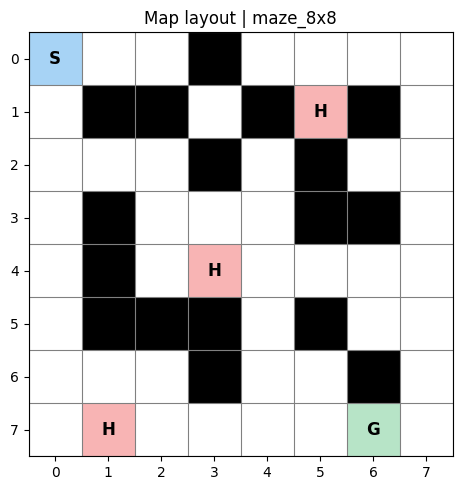

Saved GIF: assets/web_outputs/session2_large_maze_8x8_vi_value.gif
Saved GIF: assets/web_outputs/session2_large_maze_8x8_pi_evolution.gif
Saved GIF: assets/web_outputs/session2_large_maze_8x8_vi_traj.gif
Saved GIF: assets/web_outputs/session2_large_maze_8x8_pi_traj.gif
Evolution GIFs: VI vs PI


Greedy rollout GIFs: VI vs PI



=== corridor_10x10 ===


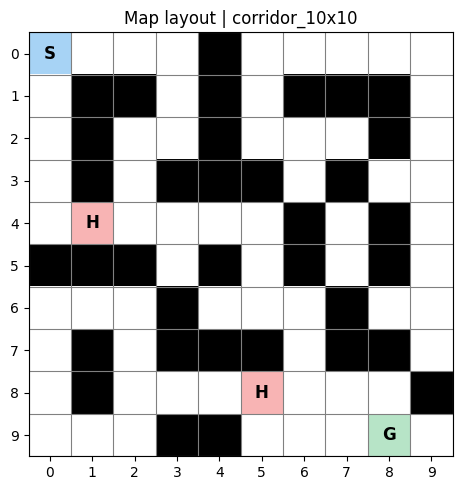

Saved GIF: assets/web_outputs/session2_large_corridor_10x10_vi_value.gif
Saved GIF: assets/web_outputs/session2_large_corridor_10x10_pi_evolution.gif
Saved GIF: assets/web_outputs/session2_large_corridor_10x10_vi_traj.gif
Saved GIF: assets/web_outputs/session2_large_corridor_10x10_pi_traj.gif
Evolution GIFs: VI vs PI


Greedy rollout GIFs: VI vs PI



=== rooms_12x12 ===


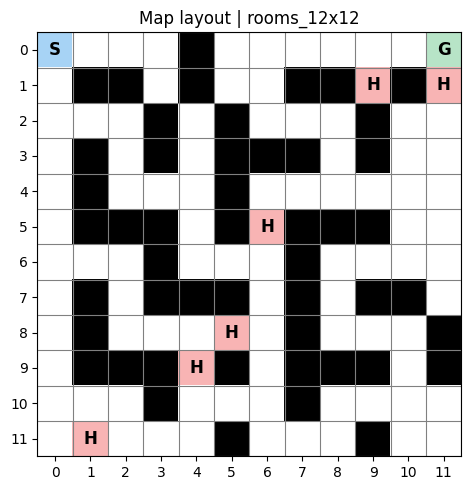

Saved GIF: assets/web_outputs/session2_large_rooms_12x12_vi_value.gif
Saved GIF: assets/web_outputs/session2_large_rooms_12x12_pi_evolution.gif
Saved GIF: assets/web_outputs/session2_large_rooms_12x12_vi_traj.gif
Saved GIF: assets/web_outputs/session2_large_rooms_12x12_pi_traj.gif
Evolution GIFs: VI vs PI


Greedy rollout GIFs: VI vs PI



Saved large-map GIFs into: assets/web_outputs


In [34]:
def _ensure_large_showcase_assets(name: str, data: dict, out_dir: Path):
    env = data["env"]
    mdp = data["mdp"]
    vi = data["vi"]
    pi = data["pi"]

    p_vi_value = out_dir / f"session2_large_{name}_vi_value.gif"
    p_pi_evo = out_dir / f"session2_large_{name}_pi_evolution.gif"
    p_vi_traj = out_dir / f"session2_large_{name}_vi_traj.gif"
    p_pi_traj = out_dir / f"session2_large_{name}_pi_traj.gif"

    save_vi_value_gif(
        mdp,
        vi["history"],
        gif_path=p_vi_value,
        title_prefix=f"VI value evolution ({name})",
        save=True,
        showcase=False,
    )
    save_policy_iteration_gif(
        mdp,
        pi["history"],
        gif_path=p_pi_evo,
        title_prefix=f"PI evolution ({name})",
        save=True,
        showcase=False,
    )

    ep_vi = rollout_with_greedy_actions(env, vi["greedy_actions"], max_steps=220)
    ep_pi = rollout_with_greedy_actions(env, np.argmax(pi["policy"], axis=1), max_steps=220)

    save_trajectory_gif(
        env,
        ep_vi["states"],
        gif_path=p_vi_traj,
        title=f"VI greedy rollout ({name})",
        trail_len=22,
        save=True,
        showcase=False,
    )
    save_trajectory_gif(
        env,
        ep_pi["states"],
        gif_path=p_pi_traj,
        title=f"PI greedy rollout ({name})",
        trail_len=22,
        save=True,
        showcase=False,
    )

    return {
        "vi_value": p_vi_value,
        "pi_evolution": p_pi_evo,
        "vi_traj": p_vi_traj,
        "pi_traj": p_pi_traj,
    }


def show_large_map_minimal_showcase(selected_maps, large_results):
    out_dir = Path("assets/web_outputs")
    out_dir.mkdir(parents=True, exist_ok=True)

    for name in selected_maps:
        data = large_results[name]
        env = data["env"]

        print(f"\n=== {name} ===")

        # 1) static map image
        render_map(env, title=f"Map layout | {name}")

        # 2-3) precompute and show only required GIF pairs
        paths = _ensure_large_showcase_assets(name, data, out_dir)

        print("Evolution GIFs: VI vs PI")
        _display_media_row([paths["vi_value"], paths["pi_evolution"]], width_px=430)

        print("Greedy rollout GIFs: VI vs PI")
        _display_media_row([paths["vi_traj"], paths["pi_traj"]], width_px=430)

    print(f"\nSaved large-map GIFs into: {out_dir}")


selected_maps = ["maze_8x8", "corridor_10x10", "rooms_12x12"]
show_large_map_minimal_showcase(selected_maps, large_results)

For each larger map, this compact showcase keeps only the visuals that matter for algorithm comparison. The static map provides structural context, the VI/PI evolution pair shows how planning information develops, and the rollout pair shows resulting control behavior. Removing extra plots keeps attention on scale effects instead of presentation noise.

## FrozenLake + Gymnasium interface essentials

This section merges the Gymnasium API basics with the FrozenLake transfer example so the full planning workflow is in one place.
Goal: clearly connect MDP notation (states, actions, rewards, transitions, terminal logic) to Gymnasium's `Env` interface and then reuse our VI/PI code on `FrozenLake-v1`.


### Gymnasium API essentials in the FrozenLake context

Core interaction pattern:
- `env = gym.make(...)`
- `obs, info = env.reset(seed=...)`
- `obs, reward, terminated, truncated, info = env.step(action)`

Space objects (how Gymnasium represents valid states/actions):
- `env.observation_space`: set of valid observations (FrozenLake: `Discrete(16)` for 4x4)
- `env.action_space`: set of valid actions (FrozenLake: `Discrete(4)`)
- `env.action_space.sample()`: random valid action (useful for sanity checks)

Semantics of step outputs:
- `obs`: next state id
- `reward`: scalar transition reward
- `terminated`: episode ended due to task terminal condition (goal/hole)
- `truncated`: episode ended due to external cutoff (e.g., time limit)
- `info`: auxiliary diagnostics

MDP notation to Gymnasium mapping:
- $A_t$ -> `action`
- $S_{t+1}$ -> `obs`
- $R_{t+1}$ -> `reward`
- $\mathcal{A}$ -> `env.action_space`
- $\mathcal{S}$ -> `env.observation_space`

For tabular planning, toy-text environments expose the model as:
- `env.unwrapped.P[s][a] = [(prob, s_next, reward, done), ...]`

FrozenLake action indexing:
- `0: Left`, `1: Down`, `2: Right`, `3: Up`


In [35]:
if gym is None:
    print("Gymnasium is not installed. Install with: pip install gymnasium[toy-text]")
else:
    fl_api_env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=False)
    obs, info = fl_api_env.reset(seed=SEED)

    print("Gymnasium import successful.")
    print(f"Observation space: {fl_api_env.observation_space}")
    print(f"Action space: {fl_api_env.action_space}")
    print(f"Reset -> obs={obs}, info={info}")

    sampled_action = int(fl_api_env.action_space.sample())
    next_obs, reward, terminated, truncated, step_info = fl_api_env.step(sampled_action)
    print(
        f"One step with sampled action {sampled_action}: "
        f"obs={next_obs}, reward={reward}, terminated={terminated}, truncated={truncated}, info={step_info}"
    )

    # Minimal random rollout to show done logic in practice
    obs, _ = fl_api_env.reset(seed=SEED)
    done = False
    t = 0
    max_steps = 30
    while not done and t < max_steps:
        a = int(fl_api_env.action_space.sample())
        obs, reward, terminated, truncated, _ = fl_api_env.step(a)
        done = terminated or truncated
        t += 1
    print(f"Random rollout finished after {t} steps (terminated={terminated}, truncated={truncated}).")
    fl_api_env.close()


Gymnasium import successful.
Observation space: Discrete(16)
Action space: Discrete(4)
Reset -> obs=0, info={'prob': 1}
One step with sampled action 3: obs=0, reward=0.0, terminated=False, truncated=False, info={'prob': 1.0}
Random rollout finished after 2 steps (terminated=True, truncated=False).


In [36]:
GYM_ACTION_SYMBOLS = {0: "←", 1: "↓", 2: "→", 3: "↑"}
GYM_ACTION_VECTORS = {
    0: (-0.35, 0.0),   # LEFT
    1: (0.0, 0.35),    # DOWN
    2: (0.35, 0.0),    # RIGHT
    3: (0.0, -0.35),   # UP
}


def frozenlake_desc_to_grid(desc) -> np.ndarray:
    # desc is byte array in Gymnasium toy-text envs
    arr = np.array(
        [[ch.decode("utf-8") if isinstance(ch, (bytes, bytearray)) else str(ch) for ch in row] for row in desc],
        dtype="<U1",
    )
    return arr


def mdp_from_frozenlake_env(env) -> TabularMDP:
    p_raw = env.unwrapped.P
    nS = env.observation_space.n
    nA = env.action_space.n

    desc = frozenlake_desc_to_grid(env.unwrapped.desc)
    H, W = desc.shape

    state_to_pos = {s: (s // W, s % W) for s in range(nS)}
    pos_to_state = {(s // W, s % W): s for s in range(nS)}

    terminal_states = set()
    start_state = 0

    for s, (r, c) in state_to_pos.items():
        cell = desc[r, c]
        if cell in ("H", "G"):
            terminal_states.add(s)
        if cell == "S":
            start_state = s

    P = {s: {a: [] for a in range(nA)} for s in range(nS)}
    for s in range(nS):
        for a in range(nA):
            for prob, s_next, reward, done in p_raw[s][a]:
                P[s][a].append((float(prob), int(s_next), float(reward), bool(done)))

    return TabularMDP(
        nS=nS,
        nA=nA,
        P=P,
        state_to_pos=state_to_pos,
        pos_to_state=pos_to_state,
        terminal_states=terminal_states,
        start_state=start_state,
        grid_chars=desc,
    )


def render_frozenlake_map(mdp: TabularMDP, title: str = "FrozenLake map"):
    code_map = {"S": 0, "F": 1, "H": 2, "G": 3}
    arr = np.vectorize(code_map.get)(mdp.grid_chars)
    cmap = ListedColormap(["#A7D3F5", "#EAF6FF", "#F8B4B4", "#B7E4C7"])

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(arr, cmap=cmap, vmin=0, vmax=3)
    ax.set_title(title)
    ax.set_xticks(range(arr.shape[1]))
    ax.set_yticks(range(arr.shape[0]))
    _draw_cell_grid(ax, arr.shape[0], arr.shape[1])

    for r in range(arr.shape[0]):
        for c in range(arr.shape[1]):
            ax.text(c, r, mdp.grid_chars[r, c], ha="center", va="center", color="black", fontsize=12, fontweight="bold")

    plt.tight_layout()
    plt.show()


def render_frozenlake_policy(mdp: TabularMDP, actions: np.ndarray, title: str = "FrozenLake policy"):
    bg = np.zeros(mdp.grid_chars.shape)
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(bg, cmap=ListedColormap(["#f7f7f7"]))
    ax.set_title(title)
    ax.set_xticks(range(bg.shape[1]))
    ax.set_yticks(range(bg.shape[0]))
    _draw_cell_grid(ax, bg.shape[0], bg.shape[1])

    for s, (r, c) in mdp.state_to_pos.items():
        cell = mdp.grid_chars[r, c]
        if cell in ("H", "G"):
            txt = cell
        elif cell == "F":
            txt = " "
        else:
            txt = GYM_ACTION_SYMBOLS[int(actions[s])]
        ax.text(c, r, txt, ha="center", va="center", color="black", fontsize=12, fontweight="bold")

    plt.tight_layout()
    plt.show()


def save_frozenlake_policy_iteration_gif(
    mdp: TabularMDP,
    history: list,
    gif_path: Path | None = None,
    title_prefix: str = "FrozenLake PI",
    save: bool = False,
    fps: int = 2,
    showcase: bool = True,
):
    if not history:
        print("No history available; GIF was not created.")
        return

    from matplotlib.animation import FuncAnimation
    value_grids = [values_to_grid(mdp, h["V"]) for h in history]

    # policy per outer iteration
    action_grids = []
    for h in history:
        a = np.argmax(h["policy"], axis=1)
        g = np.full(mdp.grid_chars.shape, -1, dtype=int)
        for s, (r, c) in mdp.state_to_pos.items():
            if mdp.grid_chars[r, c] not in ("G", "H"):
                g[r, c] = a[s]
        action_grids.append(g)

    fig, ax = plt.subplots(figsize=(5, 5))
    im = ax.imshow(value_grids[0], cmap="viridis")
    txt = ax.set_title(f"{title_prefix} | outer=1")
    ax.set_xticks(range(value_grids[0].shape[1]))
    ax.set_yticks(range(value_grids[0].shape[0]))
    _draw_cell_grid(ax, value_grids[0].shape[0], value_grids[0].shape[1])

    q = None

    def update(frame_idx):
        nonlocal q
        im.set_data(value_grids[frame_idx])

        if q is not None:
            q.remove()

        X, Y, U, V = [], [], [], []
        actions = action_grids[frame_idx]
        for r in range(actions.shape[0]):
            for c in range(actions.shape[1]):
                if mdp.grid_chars[r, c] in ("#", "G", "H"):
                    continue
                a = actions[r, c]
                if a < 0:
                    continue
                u, v = GYM_ACTION_VECTORS[a]
                X.append(c); Y.append(r); U.append(u); V.append(v)

        if X:
            q = ax.quiver(X, Y, U, V, angles="xy", scale_units="xy", scale=1, color="white", width=0.008)

        outer = history[frame_idx]["outer"]
        txt.set_text(f"{title_prefix} | outer={outer}")
        return (im, txt)

    ani = FuncAnimation(fig, update, frames=len(history), interval=550, blit=False)
    _finalize_gif_animation(ani, fig, save=save, gif_path=gif_path, fps=fps, showcase=showcase)


FrozenLake 4x4 | deterministic
  nS=16, VI_sweeps=7, PI_outer=2, PI_eval_total=100
  VI_ms=0.41, PI_ms=1.39
  L_inf(VI-PI)=0.000e+00, policy_agreement=100.0%


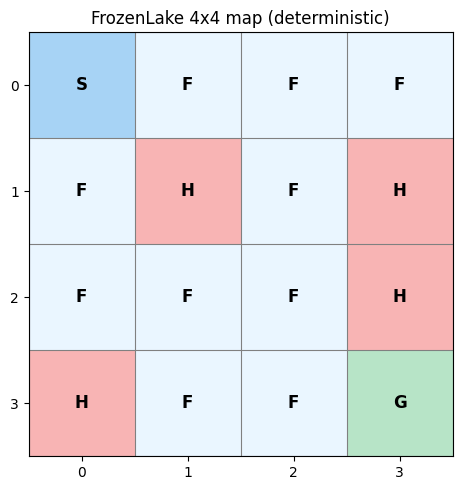

In [37]:
def run_vi_pi_on_frozenlake(map_name: str = "4x4", is_slippery: bool = False, gamma: float = 0.99, theta: float = 1e-10):
    env = gym.make("FrozenLake-v1", map_name=map_name, is_slippery=is_slippery)
    mdp = mdp_from_frozenlake_env(env)

    t0 = time.perf_counter()
    vi = value_iteration(mdp, gamma=gamma, theta=theta, return_history=True)
    t_vi_ms = (time.perf_counter() - t0) * 1e3

    t0 = time.perf_counter()
    pi = policy_iteration(mdp, gamma=gamma, eval_theta=theta, return_history=True)
    t_pi_ms = (time.perf_counter() - t0) * 1e3

    vi_actions = vi["greedy_actions"]
    pi_actions = np.argmax(pi["policy"], axis=1)

    agreement = compare_policies(vi_actions, pi_actions, mdp.terminal_states)
    value_linf = float(np.max(np.abs(vi["V"] - pi["V"])))

    return {
        "env": env,
        "mdp": mdp,
        "vi": vi,
        "pi": pi,
        "t_vi_ms": t_vi_ms,
        "t_pi_ms": t_pi_ms,
        "agreement": agreement,
        "value_linf": value_linf,
    }


if gym is None:
    print("Skip: Gymnasium not available.")
else:
    fl4 = run_vi_pi_on_frozenlake(map_name="4x4", is_slippery=False, gamma=0.99, theta=1e-10)

    mdp = fl4["mdp"]
    vi = fl4["vi"]
    pi = fl4["pi"]

    print("FrozenLake 4x4 | deterministic")
    print(f"  nS={mdp.nS}, VI_sweeps={vi['sweeps']}, PI_outer={pi['outer_loops']}, PI_eval_total={sum(pi['eval_sweeps'])}")
    print(f"  VI_ms={fl4['t_vi_ms']:.2f}, PI_ms={fl4['t_pi_ms']:.2f}")
    print(f"  L_inf(VI-PI)={fl4['value_linf']:.3e}, policy_agreement={fl4['agreement']*100:.1f}%")

    render_frozenlake_map(mdp, title="FrozenLake 4x4 map (deterministic)")

The API demo above shows the runtime interaction contract (`reset`, `step`, spaces, and termination flags).\n
\n
Bridge to planning: now we switch from interaction to model-based DP by reading `env.unwrapped.P` and converting FrozenLake into our `TabularMDP` structure via `mdp_from_frozenlake_env(...)`. From that point onward, the same Value Iteration and Policy Iteration code used for custom GridWorld runs without algorithm changes.

### FrozenLake 4x4 outputs: evolution and actual Gym rollouts

In [38]:
if gym is None:
    print("Skip: Gymnasium not available.")
elif imageio is None:
    print("Skip: imageio is not available for rollout GIF export.")
else:
    out_dir = Path("assets/web_outputs")
    out_dir.mkdir(parents=True, exist_ok=True)

    mdp = fl4["mdp"]
    vi = fl4["vi"]
    pi = fl4["pi"]

    # 1) Evolution GIFs (VI vs PI)
    gif_vi_evo = out_dir / "session2_fl4_vi_value_evolution.gif"
    gif_pi_evo = out_dir / "session2_fl4_pi_evolution.gif"

    save_vi_value_gif(
        mdp,
        vi["history"],
        gif_path=gif_vi_evo,
        title_prefix="FrozenLake VI value evolution (4x4 det)",
        save=True,
        showcase=False,
    )
    save_frozenlake_policy_iteration_gif(
        mdp,
        pi["history"],
        gif_path=gif_pi_evo,
        title_prefix="FrozenLake PI evolution (4x4 det)",
        save=True,
        showcase=False,
    )

    print("Evolution GIFs: VI vs PI")
    _display_media_row([gif_vi_evo, gif_pi_evo], width_px=430)

    def save_frozenlake_gym_rollout_gif(
        map_name: str,
        is_slippery: bool,
        actions: np.ndarray,
        gif_path: Path,
        seed: int = 7,
        max_steps: int = 120,
        duration: float = 0.22,
    ):
        env = gym.make("FrozenLake-v1", map_name=map_name, is_slippery=is_slippery, render_mode="rgb_array")
        obs, _ = env.reset(seed=seed)
        frames = [env.render()]

        for _ in range(max_steps):
            a = int(actions[int(obs)])
            obs, _, terminated, truncated, _ = env.step(a)
            frames.append(env.render())
            if terminated or truncated:
                break

        gif_path.parent.mkdir(parents=True, exist_ok=True)
        imageio.mimsave(gif_path, frames, duration=duration)
        print(f"Saved GIF: {gif_path}")

    # 2) Actual Gym rollout GIFs (VI vs PI)
    gif_vi_roll = out_dir / "session2_fl4_vi_gym_rollout.gif"
    gif_pi_roll = out_dir / "session2_fl4_pi_gym_rollout.gif"

    save_frozenlake_gym_rollout_gif(
        map_name="4x4",
        is_slippery=False,
        actions=vi["greedy_actions"],
        gif_path=gif_vi_roll,
        seed=7,
    )
    save_frozenlake_gym_rollout_gif(
        map_name="4x4",
        is_slippery=False,
        actions=np.argmax(pi["policy"], axis=1),
        gif_path=gif_pi_roll,
        seed=7,
    )

    print("Actual Gym rollout GIFs: VI vs PI")
    _display_media_row([gif_vi_roll, gif_pi_roll], width_px=430)

Saved GIF: assets/web_outputs/session2_fl4_vi_value_evolution.gif
Saved GIF: assets/web_outputs/session2_fl4_pi_evolution.gif
Evolution GIFs: VI vs PI


Saved GIF: assets/web_outputs/session2_fl4_vi_gym_rollout.gif
Saved GIF: assets/web_outputs/session2_fl4_pi_gym_rollout.gif
Actual Gym rollout GIFs: VI vs PI


The first GIF pair shows how values and greedy actions evolve during planning in the tabular abstraction. The second pair switches to actual Gym-rendered execution, so you can verify that planned policies translate into concrete environment behavior. This side-by-side view helps separate model-level convergence from real rollout dynamics.

**FrozenLake GIF outputs** are saved under `assets/web_outputs/`.

## Gambler's Problem (tabular MDP example)

Before moving to homework, we add one more classic DP example from Sutton & Barto: **Gambler's Problem**.

Setup:
- state $s \in \{0,1,\dots,100\}$ is current capital,
- terminal states: $0$ (loss) and $100$ (goal),
- action $a$ is the stake, with $a \in \{1,\dots,\min(s,100-s)\}$,
- with probability $p_h$ the coin is heads and capital increases by $a$,
- with probability $1-p_h$ capital decreases by $a$,
- reward is $1$ only when transitioning into state $100$.

This is a pure planning problem, solved here with Value Iteration.


### Extension - Implement Value Iteration for Gambler's Problem

In [57]:
def gambler_value_iteration(
    p_heads: float = 0.4,
    theta: float = 1e-12,
    gamma: float = 1.0,
    target: int = 100,
):
    # Aligned to session_02_gamblers_problem.ipynb logic (including tie handling)
    V = np.zeros(target + 1, dtype=float)
    policy = np.zeros(target + 1, dtype=int)

    history = []
    deltas = []
    sweeps = 0

    delta = theta
    while delta >= theta:
        delta = 0.0

        for s in range(1, target):
            v_old = V[s]

            best_action_value = 0.0
            best_action = 0

            for a in range(1, min(s, target - s) + 1):
                s_win = s + a
                s_lose = max(0, s - a)

                reward_win = 1.0 if s_win == target else 0.0

                action_value = 0.0
                action_value += p_heads * (reward_win + gamma * V[s_win])
                action_value += (1.0 - p_heads) * gamma * V[s_lose]

                # Same tie handling as the reference notebook
                if action_value - theta > best_action_value:
                    best_action_value = action_value
                    best_action = a

            V[s] = best_action_value
            policy[s] = best_action
            delta = max(delta, abs(v_old - best_action_value))

        history.append(V.copy())
        deltas.append(delta)
        sweeps += 1

    return {
        "V": V,
        "policy": policy,
        "history": history,
        "deltas": deltas,
        "sweeps": sweeps,
        "p_heads": p_heads,
        "theta": theta,
        "gamma": gamma,
    }


gambler_res = gambler_value_iteration(p_heads=0.4, theta=1e-12, gamma=1.0)
print(
    f"Converged in {gambler_res['sweeps']} sweeps | "
    f"final delta={gambler_res['deltas'][-1]:.3e}"
)


Converged in 22 sweeps | final delta=5.735e-13


### Extension - Visualize value function and optimal policy

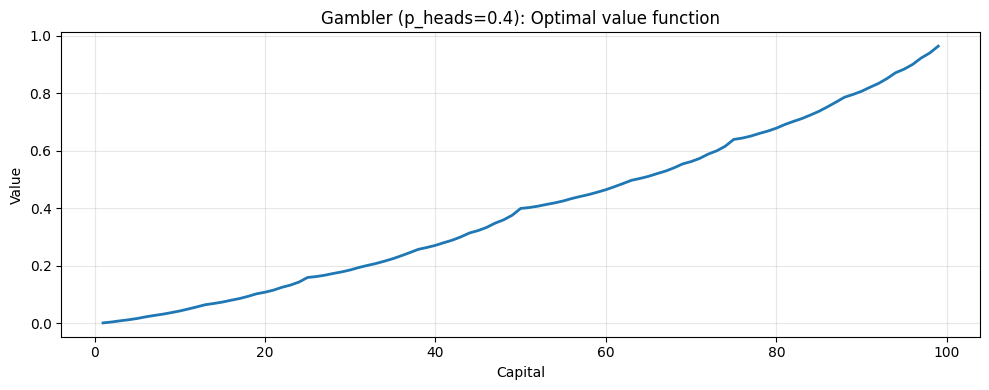

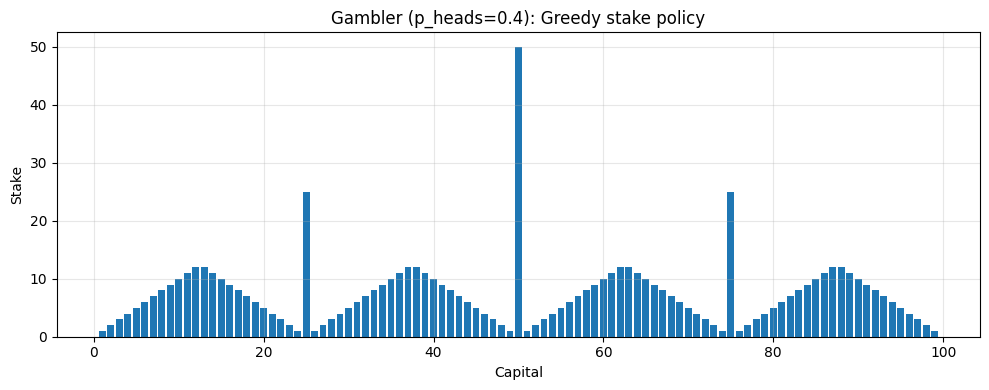

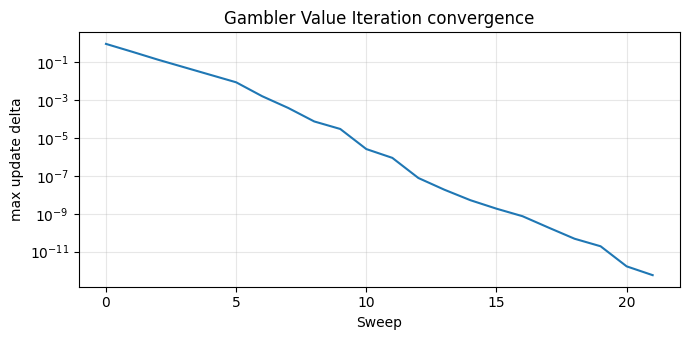

In [58]:
def plot_gambler_values_and_policy(result: dict, title_prefix: str = "Gambler"):
    V = result["V"]
    policy = result["policy"]
    target = len(V) - 1

    plt.figure(figsize=(10, 4))
    plt.plot(np.arange(1, target), V[1:target], linewidth=2)
    plt.xlabel("Capital")
    plt.ylabel("Value")
    plt.title(f"{title_prefix}: Optimal value function")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.bar(np.arange(1, target), policy[1:target])
    plt.xlabel("Capital")
    plt.ylabel("Stake")
    plt.title(f"{title_prefix}: Greedy stake policy")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_gambler_convergence(result: dict, title: str = "Gambler Value Iteration convergence"):
    deltas = result["deltas"]
    plt.figure(figsize=(7, 3.5))
    plt.plot(deltas)
    plt.yscale("log")
    plt.xlabel("Sweep")
    plt.ylabel("max update delta")
    plt.title(title)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


plot_gambler_values_and_policy(gambler_res, title_prefix="Gambler (p_heads=0.4)")
plot_gambler_convergence(gambler_res)


These Gambler plots reproduce the chapter-style behavior expected from the classic formulation. The value curve grows nonlinearly with capital because the chance of eventually hitting the goal is state dependent, and the optimal stake policy forms discrete regions rather than a smooth control law. This is a useful non-grid example of exact dynamic programming.

### Extension - Value-evolution snapshots and GIF

Saved GIF: assets/web_outputs/session2_gambler_value_evolution.gif


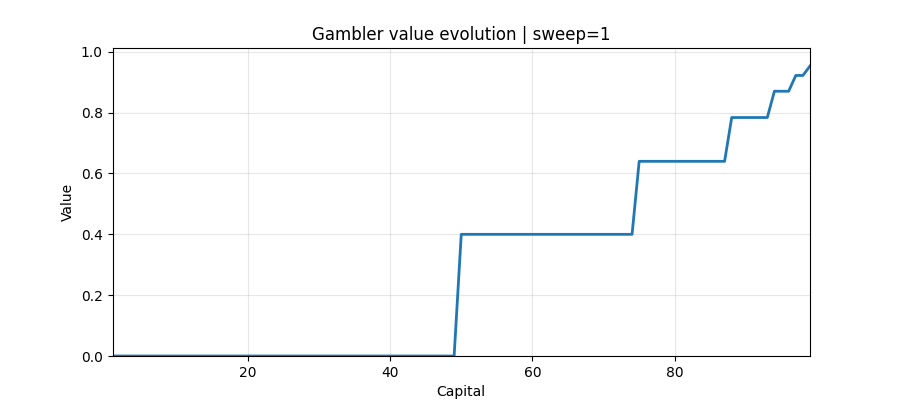

In [59]:
def plot_gambler_snapshots(
    result: dict,
    k_list=None,
    save: bool = False,
    out_dir: Path | None = None,
    file_tag: str = "gambler",
):
    hist = result["history"]
    if not hist:
        return
    if save and out_dir is None:
        raise ValueError("out_dir must be provided when save=True")

    if k_list is None:
        last = len(hist) - 1
        mid = last // 2
        k_list = sorted(set([0, mid, last]))

    fig, ax = plt.subplots(figsize=(10, 4))
    for k in k_list:
        ax.plot(np.arange(1, len(hist[k]) - 1), hist[k][1:-1], label=f"sweep={k+1}")
    ax.set_xlabel("Capital")
    ax.set_ylabel("Value")
    ax.set_title("Gambler value evolution snapshots")
    ax.grid(alpha=0.3)
    ax.legend()
    _save_or_show_fig(
        fig,
        save=save,
        path=(out_dir / f"{file_tag}_value_snapshots.png") if save else None,
    )


def save_gambler_value_gif(
    result: dict,
    gif_path: Path | None = None,
    title_prefix: str = "Gambler value evolution",
    save: bool = False,
    fps: int = 8,
):
    hist = result["history"]
    if not hist:
        print("No history available; GIF was not created.")
        return

    x = np.arange(1, len(hist[0]) - 1)
    fig, ax = plt.subplots(figsize=(9, 4))
    line, = ax.plot([], [], linewidth=2)
    ax.set_xlim(x[0], x[-1])
    ax.set_ylim(0.0, max(float(np.max(v)) for v in hist) * 1.05)
    ax.set_xlabel("Capital")
    ax.set_ylabel("Value")
    title = ax.set_title(f"{title_prefix} | sweep=1")
    ax.grid(alpha=0.3)

    def update(i):
        y = hist[i][1:-1]
        line.set_data(x, y)
        title.set_text(f"{title_prefix} | sweep={i+1}")
        return line, title

    ani = FuncAnimation(fig, update, frames=len(hist), interval=160, blit=False)
    _finalize_gif_animation(ani, fig, save=save, gif_path=gif_path, fps=fps)


out_dir = Path("assets/web_outputs")
out_dir.mkdir(parents=True, exist_ok=True)

# plot_gambler_snapshots(gambler_res, save=True, out_dir=out_dir, file_tag="session2_gambler")
save_gambler_value_gif(
    gambler_res,
    out_dir / "session2_gambler_value_evolution.gif",
    save=True,
)

### Extension - Probability sensitivity experiments

We compare $p_h \in \{0.25, 0.40, 0.55\}$ and inspect how value and policy structure changes.


p_heads | sweeps | V(50) | suggested stake at s=50
  0.25 |     19 |  0.250 |                       50
  0.40 |     22 |  0.400 |                       50
  0.55 |   2256 |  1.000 |                        1


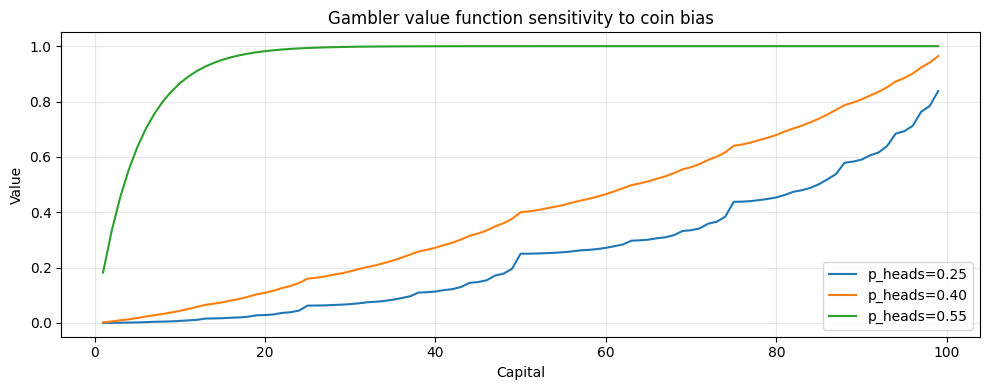

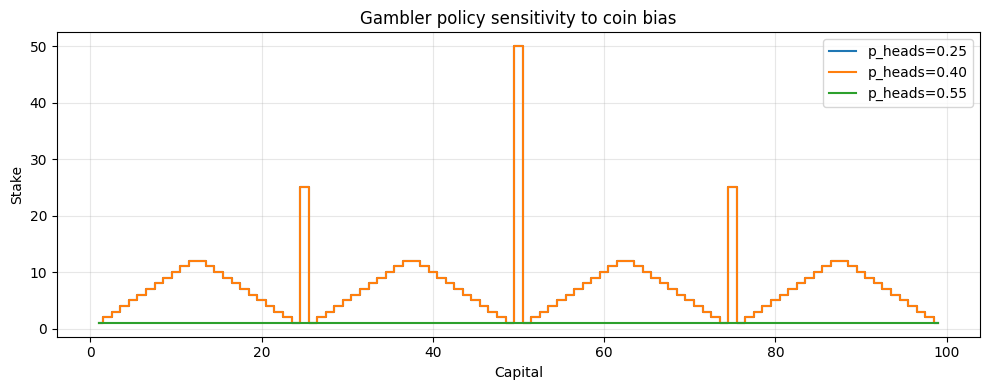

In [60]:
p_list = [0.25, 0.40, 0.55]
results = {p: gambler_value_iteration(p_heads=p, theta=1e-12, gamma=1.0) for p in p_list}

print("p_heads | sweeps | V(50) | suggested stake at s=50")
for p in p_list:
    r = results[p]
    print(f"{p:6.2f} | {r['sweeps']:6d} | {r['V'][50]:6.3f} | {r['policy'][50]:24d}")

plt.figure(figsize=(10, 4))
for p in p_list:
    r = results[p]
    plt.plot(np.arange(1, 100), r["V"][1:100], label=f"p_heads={p:.2f}")
plt.xlabel("Capital")
plt.ylabel("Value")
plt.title("Gambler value function sensitivity to coin bias")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
for p in p_list:
    r = results[p]
    plt.step(np.arange(1, 100), r["policy"][1:100], where="mid", label=f"p_heads={p:.2f}")
plt.xlabel("Capital")
plt.ylabel("Stake")
plt.title("Gambler policy sensitivity to coin bias")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


Changing coin bias directly modifies the transition model, so both value scale and optimal stakes should move in a structured way. As heads probability increases, aggressive stakes become attractive at more capitals; when it decreases, conservative behavior dominates. This sensitivity is the key teaching point of the Gambler example.